In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt



In [ ]:
# Transformations for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Load datasets into DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Data loaded and split successfully.")


100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Data loaded and split successfully.


In [ ]:
class CNN(nn.Module):
    def __init__(self, kernel_size1=3, kernel_size2=3):
        super(CNN, self).__init__()
        # Feature extraction part
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size2, padding=1)

        # Fully connected layer sizes will be adjusted dynamically
        self.flatten_size = None  # This will be calculated dynamically in forward pass
        self.fc1 = None
        self.fc2 = nn.Linear(256, 10)  # Final classification layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Dynamically calculate the flattened size
        if self.flatten_size is None:
            self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_size, 256).cuda()

        x = x.view(-1, self.flatten_size)  # Flatten feature map
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
def train_and_validate(kernel_size1=3, kernel_size2=3, epochs=10, learning_rate=0.001):
    # Instantiate model, loss, and optimizer
    model = CNN(kernel_size1=kernel_size1, kernel_size2=kernel_size2).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    training_losses = []
    validation_losses = []
    validation_accuracies = []
    memory_usage = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        torch.cuda.reset_peak_memory_stats()  # Reset memory tracking
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        training_loss = running_loss / len(train_loader)
        training_losses.append(training_loss)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        validation_losses.append(val_loss)
        validation_accuracies.append(100 * correct / total)

        # Record memory usage
        max_memory = torch.cuda.max_memory_allocated() / 1e6  # Convert to MB
        memory_usage.append(max_memory)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Training Loss: {training_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {100 * correct / total:.2f}%, "
              f"Max Memory Usage: {max_memory:.2f} MB")

    # Plot results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), training_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return memory_usage


Experiment with kernel sizes 3x3
Epoch 1/10, Training Loss: 1.7642, Validation Loss: 1.5584, Validation Accuracy: 44.78%, Max Memory Usage: 111.53 MB
Epoch 2/10, Training Loss: 1.4570, Validation Loss: 1.4238, Validation Accuracy: 49.32%, Max Memory Usage: 111.53 MB
Epoch 3/10, Training Loss: 1.3423, Validation Loss: 1.3607, Validation Accuracy: 51.70%, Max Memory Usage: 111.53 MB
Epoch 4/10, Training Loss: 1.2760, Validation Loss: 1.3050, Validation Accuracy: 53.94%, Max Memory Usage: 111.53 MB
Epoch 5/10, Training Loss: 1.2324, Validation Loss: 1.2919, Validation Accuracy: 54.92%, Max Memory Usage: 111.53 MB
Epoch 6/10, Training Loss: 1.1999, Validation Loss: 1.2716, Validation Accuracy: 54.70%, Max Memory Usage: 111.53 MB
Epoch 7/10, Training Loss: 1.1713, Validation Loss: 1.2531, Validation Accuracy: 56.20%, Max Memory Usage: 111.53 MB
Epoch 8/10, Training Loss: 1.1482, Validation Loss: 1.2342, Validation Accuracy: 56.76%, Max Memory Usage: 111.53 MB
Epoch 9/10, Training Loss: 1.12

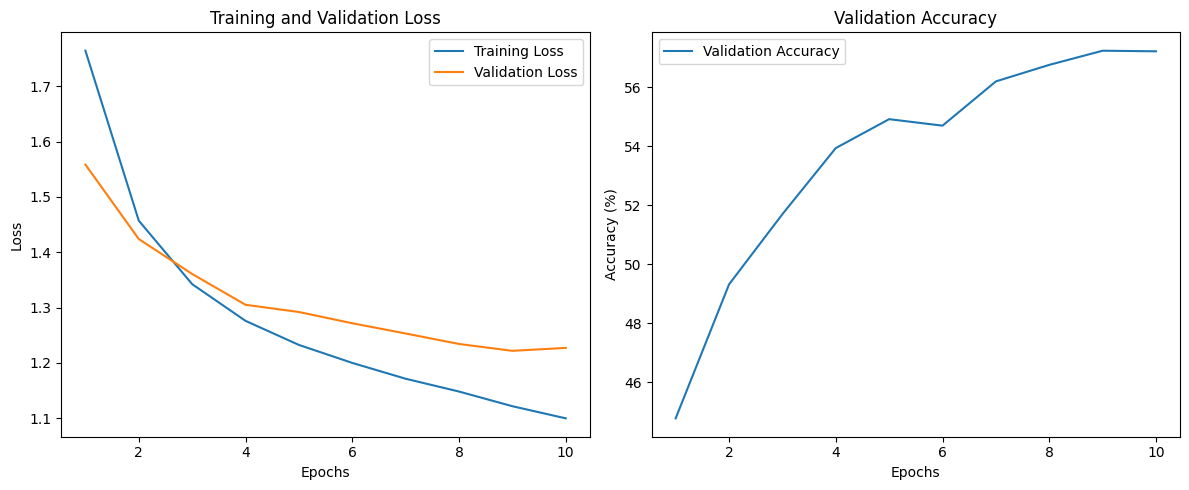

memory_usage = [111.533056, 111.53408, 111.53408, 111.53408, 111.53408, 111.53408, 111.53408, 111.53408, 111.53408, 111.53408]
Experiment with kernel sizes 5x5
Epoch 1/10, Training Loss: 1.6789, Validation Loss: 1.4500, Validation Accuracy: 47.88%, Max Memory Usage: 105.78 MB
Epoch 2/10, Training Loss: 1.3549, Validation Loss: 1.3226, Validation Accuracy: 52.98%, Max Memory Usage: 105.79 MB
Epoch 3/10, Training Loss: 1.2353, Validation Loss: 1.2385, Validation Accuracy: 56.10%, Max Memory Usage: 105.79 MB
Epoch 4/10, Training Loss: 1.1550, Validation Loss: 1.1932, Validation Accuracy: 58.44%, Max Memory Usage: 105.79 MB
Epoch 5/10, Training Loss: 1.0897, Validation Loss: 1.1627, Validation Accuracy: 59.72%, Max Memory Usage: 105.79 MB
Epoch 6/10, Training Loss: 1.0339, Validation Loss: 1.1388, Validation Accuracy: 60.62%, Max Memory Usage: 105.79 MB
Epoch 7/10, Training Loss: 0.9946, Validation Loss: 1.1109, Validation Accuracy: 61.76%, Max Memory Usage: 105.79 MB
Epoch 8/10, Training 

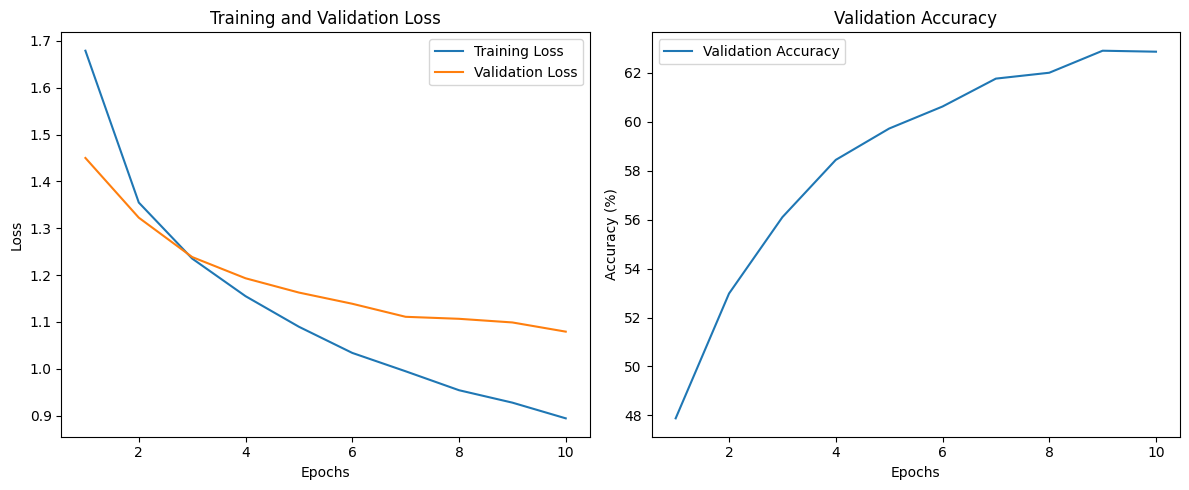

memory_usage = [105.78432, 105.785344, 105.785344, 105.785344, 105.785856, 105.785344, 105.785344, 105.785344, 105.785344, 105.785344]
Experiment with kernel sizes 3x3 and 5x5
Epoch 1/10, Training Loss: 1.6878, Validation Loss: 1.4806, Validation Accuracy: 45.76%, Max Memory Usage: 110.81 MB
Epoch 2/10, Training Loss: 1.3640, Validation Loss: 1.3261, Validation Accuracy: 52.54%, Max Memory Usage: 110.81 MB
Epoch 3/10, Training Loss: 1.2394, Validation Loss: 1.2509, Validation Accuracy: 56.72%, Max Memory Usage: 110.81 MB
Epoch 4/10, Training Loss: 1.1675, Validation Loss: 1.2014, Validation Accuracy: 57.70%, Max Memory Usage: 110.81 MB
Epoch 5/10, Training Loss: 1.1077, Validation Loss: 1.2213, Validation Accuracy: 57.12%, Max Memory Usage: 110.81 MB
Epoch 6/10, Training Loss: 1.0593, Validation Loss: 1.1482, Validation Accuracy: 59.64%, Max Memory Usage: 110.81 MB
Epoch 7/10, Training Loss: 1.0210, Validation Loss: 1.1356, Validation Accuracy: 59.30%, Max Memory Usage: 110.81 MB
Epoch

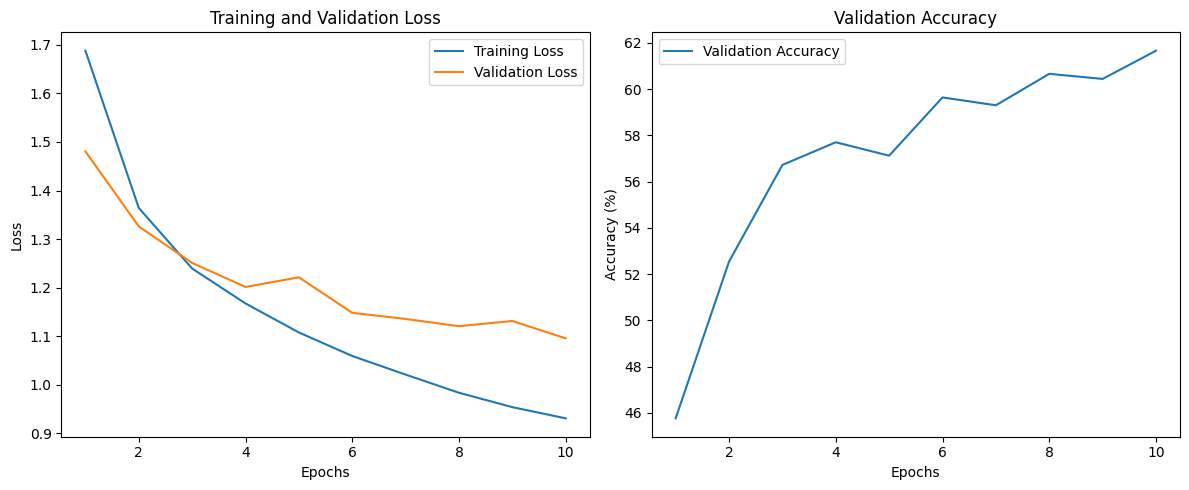

memory_usage = [110.81216, 110.813184, 110.813184, 110.813184, 110.813184, 110.813184, 110.813184, 110.813184, 110.813184, 110.813184]


In [ ]:
# Experiment 1: Kernel sizes 3x3 for both layers
print("Experiment with kernel sizes 3x3")
memory_usage = train_and_validate(kernel_size1=3, kernel_size2=3)
print(f'memory_usage = {memory_usage}')

# Experiment 2: Kernel sizes 5x5 for both layers
print("Experiment with kernel sizes 5x5")
memory_usage = train_and_validate(kernel_size1=5, kernel_size2=5)
print(f'memory_usage = {memory_usage}')

# Experiment 3: Mixed kernel sizes (3x3 and 5x5)
print("Experiment with kernel sizes 3x3 and 5x5")
memory_usage = train_and_validate(kernel_size1=3, kernel_size2=5)
print(f'memory_usage = {memory_usage}')


# Analyzing the Effect of Kernel Size on CNN Performance Using the CIFAR-10 Dataset
## Introduction

This experiment evaluates the effect of different kernel sizes on the performance of a Convolutional Neural Network (CNN) designed to classify images from the CIFAR-10 dataset. The analysis includes training loss, validation loss, accuracy, and GPU memory usage for three configurations:

* Both convolutional layers using a kernel size of 3×3.
* Both convolutional layers using a kernel size of 5×5.
* A combination: the first layer using 3×3 and the second layer using 5×5.

## Dataset and Preprocessing
* Dataset: CIFAR-10, containing 60,000 32x32 color images in 10 classes.
* Preprocessing: Images were normalized and split into training (70%), validation (10%), and testing (20%) sets.

## Model Architecture
The CNN consists of:

* Feature Extraction:
** Two convolutional layers, each followed by a max pooling layer.
** Kernel sizes varied as per the experiment configurations.
* Classification:
** Two fully connected layers.
** Activation Function: ReLU.
** Loss Function: CrossEntropyLoss.
** Optimizer: Adam with a fixed learning rate of 0.001.
** Batch Size: 64.

## Experimental Configurations
* 1- Kernel Size 3×3 (Both Layers):
** Both convolutional layers used a 3×3 kernel with padding.
* 2- Kernel Size 5×5 (Both Layers):
** Both convolutional layers used a 5×5 kernel with padding.
* 3- Mixed Kernel Sizes (3×3 and 5×5):
** The first layer used a 3×3 kernel, and the second layer used a 5×5 kernel.

## Results Summary
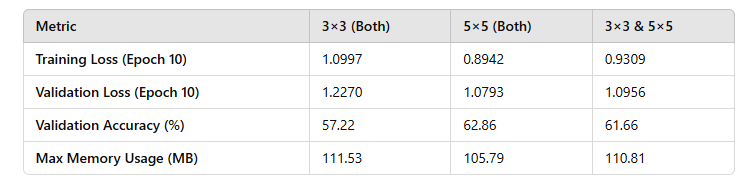

# Observations
* Performance and Accuracy:
** Larger kernel sizes (5×5) resulted in better feature extraction and higher validation accuracy compared to smaller kernels (3×3).
** Mixed kernel sizes achieved results between the two extremes, suggesting flexibility in combining kernel sizes for trade-offs in accuracy and complexity.
* Loss Trends:
** Training and validation losses consistently decreased over epochs for all configurations.
** The 5×5 kernel configuration converged faster, indicating its ability to capture broader spatial features.
* Memory Usage:
** Using larger kernels (5×5) reduced GPU memory usage slightly compared to 3×3 kernels. This result is due to fewer computations at each layer due to reduced resolution after pooling.
* Trade-offs:
** While larger kernels improved accuracy and reduced memory usage, they increased computational cost per convolution.
* Graphical Analysis

Two plots were generated for each configuration:

* Training and Validation Loss over epochs.
* Validation Accuracy over epochs.

## Conclusion
Kernel size significantly impacts feature extraction, model accuracy, and resource usage:

* Larger kernels (5×5) are better for broader feature recognition but may increase training time.
* Smaller kernels (3×3) are effective for finer features but require higher memory due to denser operations.
* Mixed configurations offer a balanced approach.


In [ ]:
class RegularizedCNN(nn.Module):
    def __init__(self, kernel_size1=3, kernel_size2=3, dropout_rate=0.0, use_batch_norm=False):
        super(RegularizedCNN, self).__init__()
        self.use_batch_norm = use_batch_norm

        # Feature extraction part
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Optional batch normalization layers
        self.bn1 = nn.BatchNorm2d(32) if use_batch_norm else None
        self.bn2 = nn.BatchNorm2d(64) if use_batch_norm else None

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        if self.use_batch_norm: x = self.bn1(x)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        if self.use_batch_norm: x = self.bn2(x)
        x = self.pool(x)

        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:
def train_and_validate_regularized_model(dropout_rate=0.0, use_batch_norm=False, epochs=10, learning_rate=0.001):
    # Instantiate model
    model = RegularizedCNN(dropout_rate=dropout_rate, use_batch_norm=use_batch_norm).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store metrics for plotting
    training_losses = []
    validation_losses = []
    validation_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        training_loss = running_loss / len(train_loader)
        training_losses.append(training_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        validation_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        validation_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Training Loss: {training_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.2f}%")

    # Plotting the results
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), training_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return training_losses, validation_losses, validation_accuracies


Baseline Model (No Dropout, No Batch Normalization):
Epoch 1/10, Training Loss: 1.3849, Validation Loss: 1.1485, Validation Accuracy: 59.20%
Epoch 2/10, Training Loss: 1.0094, Validation Loss: 1.0304, Validation Accuracy: 64.02%
Epoch 3/10, Training Loss: 0.8391, Validation Loss: 0.9825, Validation Accuracy: 65.54%
Epoch 4/10, Training Loss: 0.7058, Validation Loss: 0.8962, Validation Accuracy: 68.48%
Epoch 5/10, Training Loss: 0.5726, Validation Loss: 0.8745, Validation Accuracy: 70.26%
Epoch 6/10, Training Loss: 0.4452, Validation Loss: 0.9308, Validation Accuracy: 70.30%
Epoch 7/10, Training Loss: 0.3204, Validation Loss: 1.0207, Validation Accuracy: 70.80%
Epoch 8/10, Training Loss: 0.2220, Validation Loss: 1.1881, Validation Accuracy: 69.36%
Epoch 9/10, Training Loss: 0.1479, Validation Loss: 1.2907, Validation Accuracy: 70.32%
Epoch 10/10, Training Loss: 0.1058, Validation Loss: 1.3974, Validation Accuracy: 70.22%


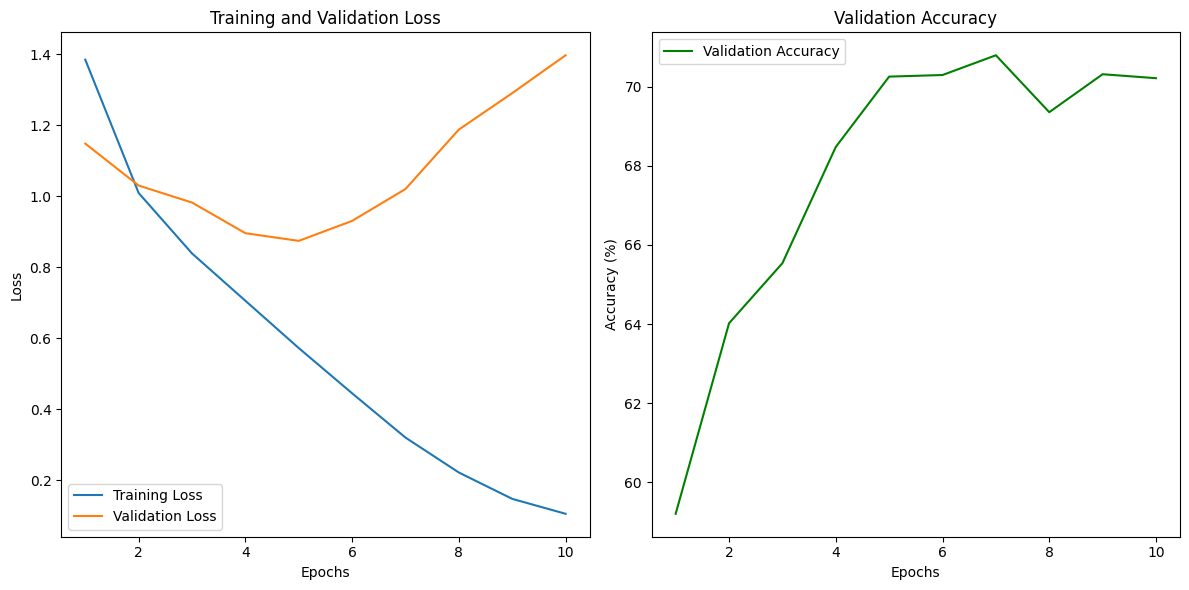

Experiment with Dropout (Rate = 0.3):
Epoch 1/10, Training Loss: 1.4820, Validation Loss: 1.1770, Validation Accuracy: 58.56%
Epoch 2/10, Training Loss: 1.1055, Validation Loss: 1.0106, Validation Accuracy: 64.14%
Epoch 3/10, Training Loss: 0.9420, Validation Loss: 0.9302, Validation Accuracy: 67.26%
Epoch 4/10, Training Loss: 0.8351, Validation Loss: 0.9082, Validation Accuracy: 68.56%
Epoch 5/10, Training Loss: 0.7427, Validation Loss: 0.8987, Validation Accuracy: 69.40%
Epoch 6/10, Training Loss: 0.6517, Validation Loss: 0.8821, Validation Accuracy: 70.32%
Epoch 7/10, Training Loss: 0.5807, Validation Loss: 0.8646, Validation Accuracy: 71.40%
Epoch 8/10, Training Loss: 0.5115, Validation Loss: 0.8828, Validation Accuracy: 71.16%
Epoch 9/10, Training Loss: 0.4448, Validation Loss: 0.9323, Validation Accuracy: 70.54%
Epoch 10/10, Training Loss: 0.3900, Validation Loss: 1.0012, Validation Accuracy: 69.78%


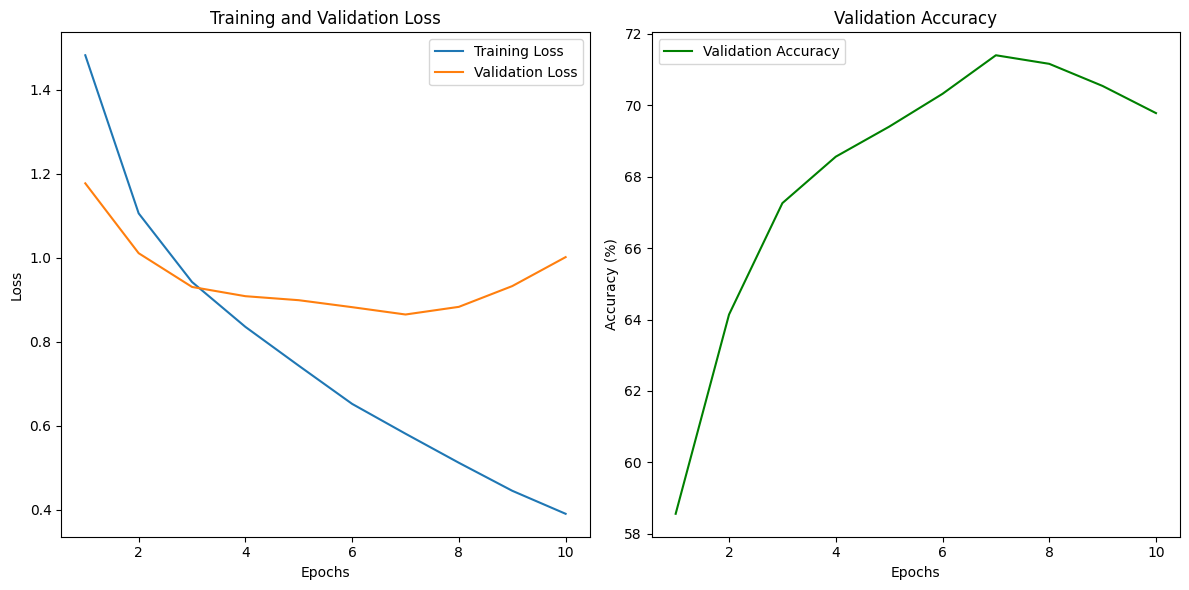

Experiment with Dropout (Rate = 0.5):
Epoch 1/10, Training Loss: 1.5529, Validation Loss: 1.2368, Validation Accuracy: 56.64%
Epoch 2/10, Training Loss: 1.2004, Validation Loss: 1.0651, Validation Accuracy: 61.98%
Epoch 3/10, Training Loss: 1.0408, Validation Loss: 0.9902, Validation Accuracy: 65.10%
Epoch 4/10, Training Loss: 0.9416, Validation Loss: 0.9273, Validation Accuracy: 67.82%
Epoch 5/10, Training Loss: 0.8477, Validation Loss: 0.8927, Validation Accuracy: 69.04%
Epoch 6/10, Training Loss: 0.7816, Validation Loss: 0.8812, Validation Accuracy: 68.88%
Epoch 7/10, Training Loss: 0.7174, Validation Loss: 0.8537, Validation Accuracy: 70.38%
Epoch 8/10, Training Loss: 0.6579, Validation Loss: 0.8634, Validation Accuracy: 70.44%
Epoch 9/10, Training Loss: 0.6016, Validation Loss: 0.8829, Validation Accuracy: 70.08%
Epoch 10/10, Training Loss: 0.5446, Validation Loss: 0.8709, Validation Accuracy: 71.76%


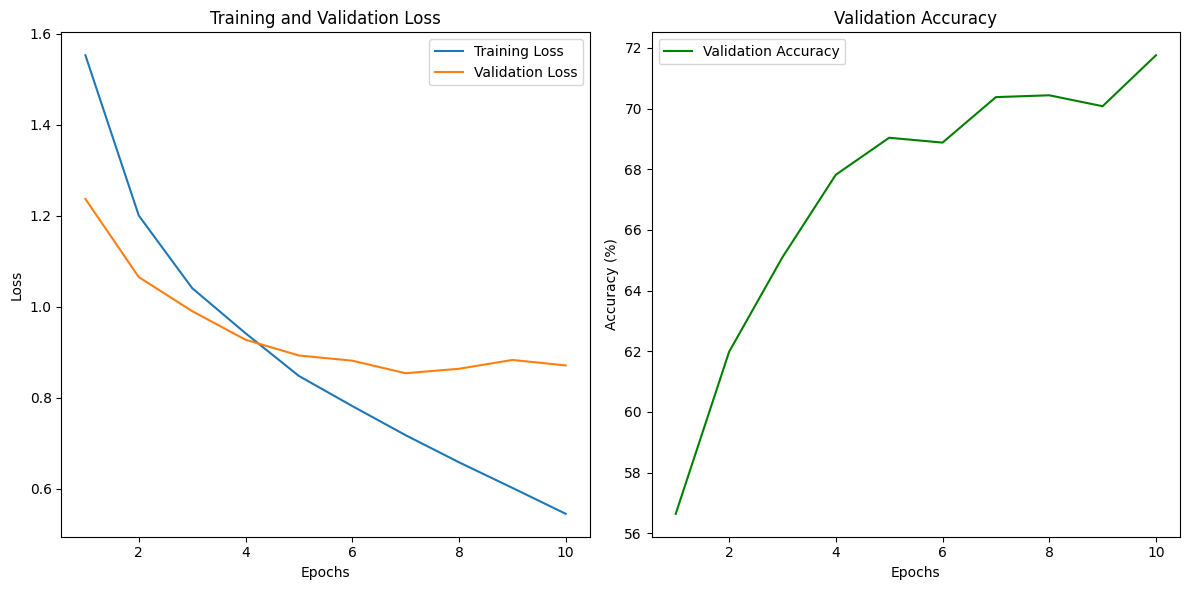

Experiment with Dropout (Rate = 0.7):
Epoch 1/10, Training Loss: 1.6931, Validation Loss: 1.3260, Validation Accuracy: 52.02%
Epoch 2/10, Training Loss: 1.3959, Validation Loss: 1.1929, Validation Accuracy: 57.20%
Epoch 3/10, Training Loss: 1.2579, Validation Loss: 1.0867, Validation Accuracy: 62.26%
Epoch 4/10, Training Loss: 1.1669, Validation Loss: 1.0483, Validation Accuracy: 62.72%
Epoch 5/10, Training Loss: 1.0933, Validation Loss: 0.9836, Validation Accuracy: 64.88%
Epoch 6/10, Training Loss: 1.0387, Validation Loss: 0.9656, Validation Accuracy: 66.60%
Epoch 7/10, Training Loss: 0.9878, Validation Loss: 0.9435, Validation Accuracy: 66.42%
Epoch 8/10, Training Loss: 0.9437, Validation Loss: 0.9047, Validation Accuracy: 68.50%
Epoch 9/10, Training Loss: 0.9024, Validation Loss: 0.8927, Validation Accuracy: 68.54%
Epoch 10/10, Training Loss: 0.8690, Validation Loss: 0.8911, Validation Accuracy: 69.12%


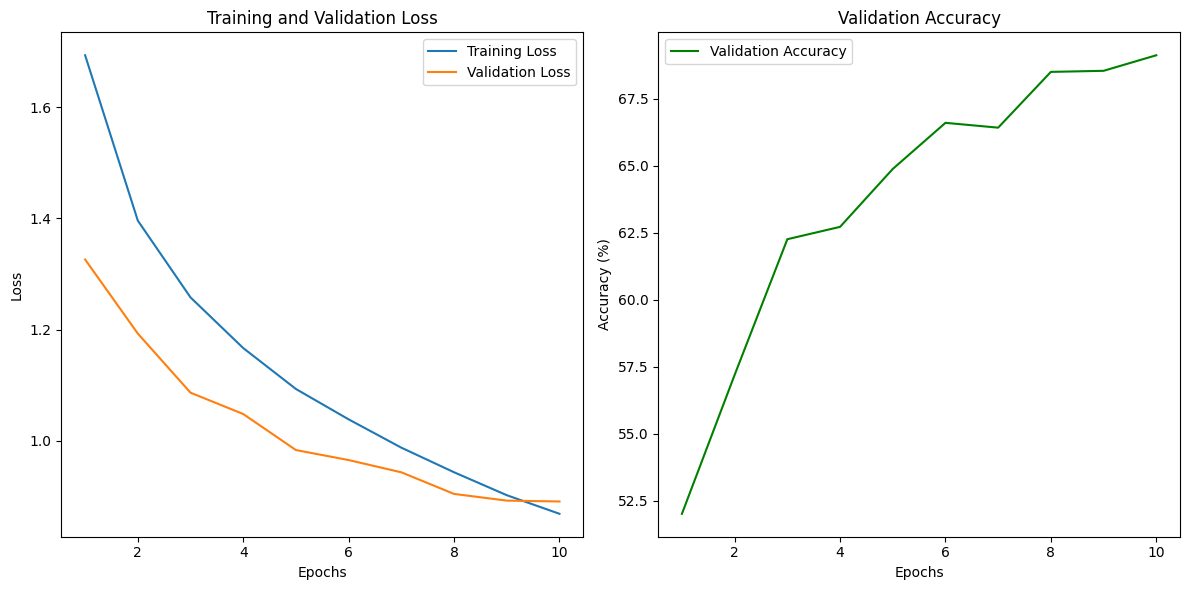

Experiment with Batch Normalization (No Dropout):
Epoch 1/10, Training Loss: 1.2061, Validation Loss: 1.0233, Validation Accuracy: 64.32%
Epoch 2/10, Training Loss: 0.8051, Validation Loss: 0.9059, Validation Accuracy: 68.66%
Epoch 3/10, Training Loss: 0.5721, Validation Loss: 0.9010, Validation Accuracy: 70.52%
Epoch 4/10, Training Loss: 0.3641, Validation Loss: 1.1089, Validation Accuracy: 68.82%
Epoch 5/10, Training Loss: 0.2098, Validation Loss: 1.1877, Validation Accuracy: 69.40%
Epoch 6/10, Training Loss: 0.1301, Validation Loss: 1.2633, Validation Accuracy: 69.88%
Epoch 7/10, Training Loss: 0.0961, Validation Loss: 1.4439, Validation Accuracy: 69.80%
Epoch 8/10, Training Loss: 0.0865, Validation Loss: 1.6576, Validation Accuracy: 69.48%
Epoch 9/10, Training Loss: 0.0893, Validation Loss: 1.6724, Validation Accuracy: 70.24%
Epoch 10/10, Training Loss: 0.0790, Validation Loss: 1.8893, Validation Accuracy: 69.28%


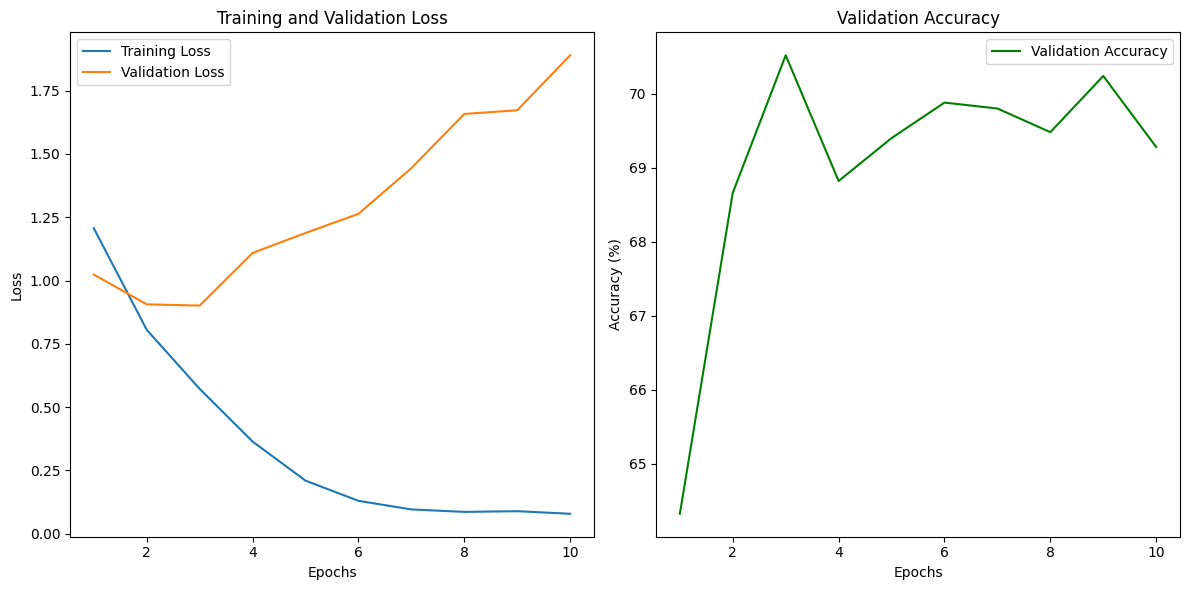

Experiment with Combined Regularization (Dropout Rate = 0.5 + Batch Normalization):
Epoch 1/10, Training Loss: 1.4192, Validation Loss: 1.0663, Validation Accuracy: 61.52%
Epoch 2/10, Training Loss: 1.0713, Validation Loss: 0.9712, Validation Accuracy: 65.58%
Epoch 3/10, Training Loss: 0.9120, Validation Loss: 0.8540, Validation Accuracy: 70.02%
Epoch 4/10, Training Loss: 0.7857, Validation Loss: 0.8903, Validation Accuracy: 69.16%
Epoch 5/10, Training Loss: 0.6834, Validation Loss: 0.8330, Validation Accuracy: 72.46%
Epoch 6/10, Training Loss: 0.5950, Validation Loss: 0.8688, Validation Accuracy: 72.08%
Epoch 7/10, Training Loss: 0.5209, Validation Loss: 0.8924, Validation Accuracy: 72.64%
Epoch 8/10, Training Loss: 0.4546, Validation Loss: 0.9120, Validation Accuracy: 72.46%
Epoch 9/10, Training Loss: 0.4210, Validation Loss: 0.9099, Validation Accuracy: 72.14%
Epoch 10/10, Training Loss: 0.3545, Validation Loss: 0.9221, Validation Accuracy: 73.40%


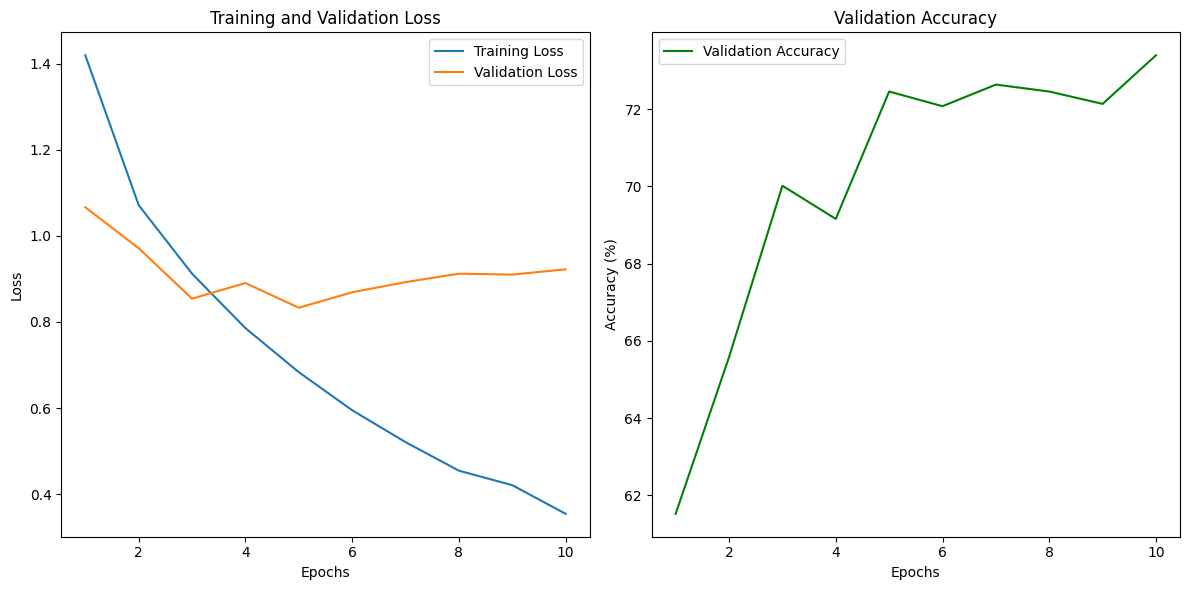

([1.4192178263524768,
  1.0712718643261703,
  0.9119992493711399,
  0.7856723285898212,
  0.6833902220948305,
  0.5949788009662733,
  0.5209157151430572,
  0.4546463441042403,
  0.420955727098193,
  0.3544743987689071],
 [1.0662528691412527,
  0.9712380170822144,
  0.8540213930455944,
  0.8903149223025841,
  0.8330166656759721,
  0.8688152409807036,
  0.8924142261849174,
  0.9120244142375414,
  0.909908807730373,
  0.9220907061914855],
 [61.52, 65.58, 70.02, 69.16, 72.46, 72.08, 72.64, 72.46, 72.14, 73.4])

In [ ]:
print("Baseline Model (No Dropout, No Batch Normalization):")
train_and_validate_regularized_model(dropout_rate=0.0, use_batch_norm=False)

print("Experiment with Dropout (Rate = 0.3):")
train_and_validate_regularized_model(dropout_rate=0.3, use_batch_norm=False)

print("Experiment with Dropout (Rate = 0.5):")
train_and_validate_regularized_model(dropout_rate=0.5, use_batch_norm=False)

print("Experiment with Dropout (Rate = 0.7):")
train_and_validate_regularized_model(dropout_rate=0.7, use_batch_norm=False)

print("Experiment with Batch Normalization (No Dropout):")
train_and_validate_regularized_model(dropout_rate=0.0, use_batch_norm=True)

print("Experiment with Combined Regularization (Dropout Rate = 0.5 + Batch Normalization):")
train_and_validate_regularized_model(dropout_rate=0.5, use_batch_norm=True)


# Observing the Training and Validation Performance
The model performance varied depending on the choice of regularization techniques (dropout, batch normalization, or their combination):

* Baseline Model (No Dropout, No Batch Normalization):
** Training Loss steadily decreases, but Validation Loss starts increasing after a few epochs (epoch 6 onwards). This suggests overfitting.
** Validation Accuracy plateaus at around 70%, and the gap between training and validation losses widens.

* Dropout Regularization:
** Adding dropout with rates (0.3, 0.5, 0.7) resulted in slower initial training and higher training loss, as expected. This is due to the random dropping of neurons.
** Validation Loss was more stable, indicating reduced overfitting.
Optimal performance occurred at Dropout = 0.5, achieving a balance between reduced overfitting and maintaining sufficient model capacity.

* Batch Normalization Only:
** Faster convergence and lower Training Loss initially, but Validation Loss increased significantly in later epochs, similar to the baseline model.
** This shows that while batch normalization stabilizes training, it doesn't inherently mitigate overfitting.

* Combined Regularization (Dropout = 0.5 + Batch Normalization):
** The combination yielded the best validation accuracy (73.4%) and relatively stable validation loss. Dropout helped control overfitting, while batch normalization improved optimization stability.
** Training Loss was higher compared to the baseline due to dropout, but this trade-off is acceptable for better generalization.

# How Do Regularization Techniques Impact Generalization?

* Dropout:
** Helps reduce overfitting by randomly deactivating neurons during training, forcing the network to rely on multiple pathways rather than over-specializing. ** However, excessive dropout (e.g., 0.7) can reduce model capacity too much, leading to underfitting.

* Batch Normalization:
** Stabilizes and accelerates training by normalizing activations, reducing internal covariate shift. While this technique makes optimization smoother and faster, it doesn't inherently address overfitting unless combined with dropout or other regularization.

* Combined Regularization:
** Combining dropout and batch normalization leverages the strengths of both techniques: reduced overfitting from dropout and faster convergence from batch normalization. This synergistic effect explains why the combined approach achieved the best validation accuracy.

# Key Observations
* Dropout alone improves generalization but may slow down training.
* Batch normalization alone speeds up training but doesn't fully address overfitting.
* The combination of both techniques provides the best trade-off between reducing overfitting and maintaining optimization stability.


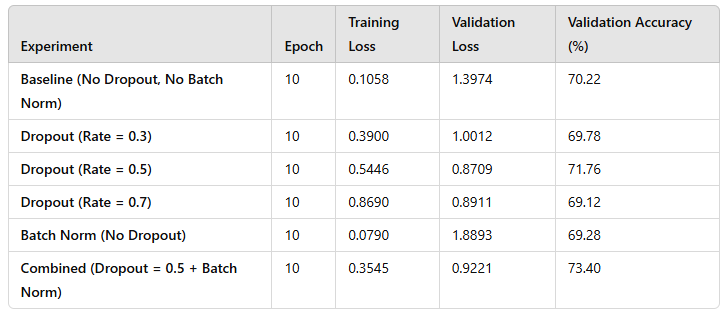

In [ ]:
def train_and_validate_batch_size(batch_size, epochs=10, learning_rate=0.001):
    # Update DataLoader with new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Model setup
    model = CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        end_time = time.time()

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        print(f"Batch Size: {batch_size}, Epoch {epoch+1}/{epochs}, "
              f"Training Loss: {running_loss/len(train_loader):.4f}, "
              f"Validation Loss: {val_loss/len(val_loader):.4f}, "
              f"Validation Accuracy: {100 * correct / total:.2f}%, "
              f"Epoch Time: {end_time - start_time:.2f} seconds")


In [ ]:
print("Experiment without Batch")
train_and_validate_batch_size(batch_size=1)

print("Experiment with Batch Size = 16")
train_and_validate_batch_size(batch_size=16)

print("Experiment with Batch Size = 64")
train_and_validate_batch_size(batch_size=64)

print("Experiment with Batch Size = 256")
train_and_validate_batch_size(batch_size=256)


Experiment without Batch
Batch Size: 1, Epoch 1/10, Training Loss: 1.4730, Validation Loss: 1.3191, Validation Accuracy: 53.06%, Epoch Time: 173.45 seconds
Batch Size: 1, Epoch 2/10, Training Loss: 1.2312, Validation Loss: 1.2024, Validation Accuracy: 56.94%, Epoch Time: 173.57 seconds
Batch Size: 1, Epoch 3/10, Training Loss: 1.1441, Validation Loss: 1.1864, Validation Accuracy: 58.52%, Epoch Time: 177.43 seconds
Batch Size: 1, Epoch 4/10, Training Loss: 1.0992, Validation Loss: 1.1841, Validation Accuracy: 58.68%, Epoch Time: 172.36 seconds
Batch Size: 1, Epoch 5/10, Training Loss: 1.0673, Validation Loss: 1.1361, Validation Accuracy: 60.54%, Epoch Time: 179.09 seconds
Batch Size: 1, Epoch 6/10, Training Loss: 1.0389, Validation Loss: 1.1639, Validation Accuracy: 60.28%, Epoch Time: 172.69 seconds
Batch Size: 1, Epoch 7/10, Training Loss: 1.0156, Validation Loss: 1.1316, Validation Accuracy: 60.40%, Epoch Time: 171.64 seconds
Batch Size: 1, Epoch 8/10, Training Loss: 0.9992, Validati

# Batch Size Impact on Model Performance
## Objective

The objective of this experiment is to analyze the impact of varying batch sizes (1, 16, 64, 256) on the training and validation performance of a CNN model. Metrics such as training loss, validation loss, validation accuracy, and epoch time are examined over 10 epochs.

## Methodology
* Dataset and Model:
** A Convolutional Neural Network (CNN) was trained on a dataset with four different batch sizes.
** The model used cross-entropy loss and Adam optimizer with a learning rate of 0.001.
* Experimental Setup:
** Training and validation data were loaded with the specified batch sizes.
** Each batch size experiment ran for 10 epochs.
* Metrics Tracked:
** Training Loss: The average loss during the training phase of each epoch.
** Validation Loss: The loss calculated on the validation set at the end of each epoch.
** Validation Accuracy: The percentage of correctly predicted samples on the validation set.
** Epoch Time: The time taken to complete one epoch.
* Batch Sizes Tested:
** Batch Size 1: Single data point at a time.
** Batch Size 16: A moderately small batch size.
** Batch Size 64: A medium batch size for balanced training.
** Batch Size 256: A large batch size to test the trade-off between speed and gradient approximation accuracy.

## Results Overview
* Loss Curves: Below are the loss curves for each batch size. Each plot shows the training and validation loss over 10 epochs.

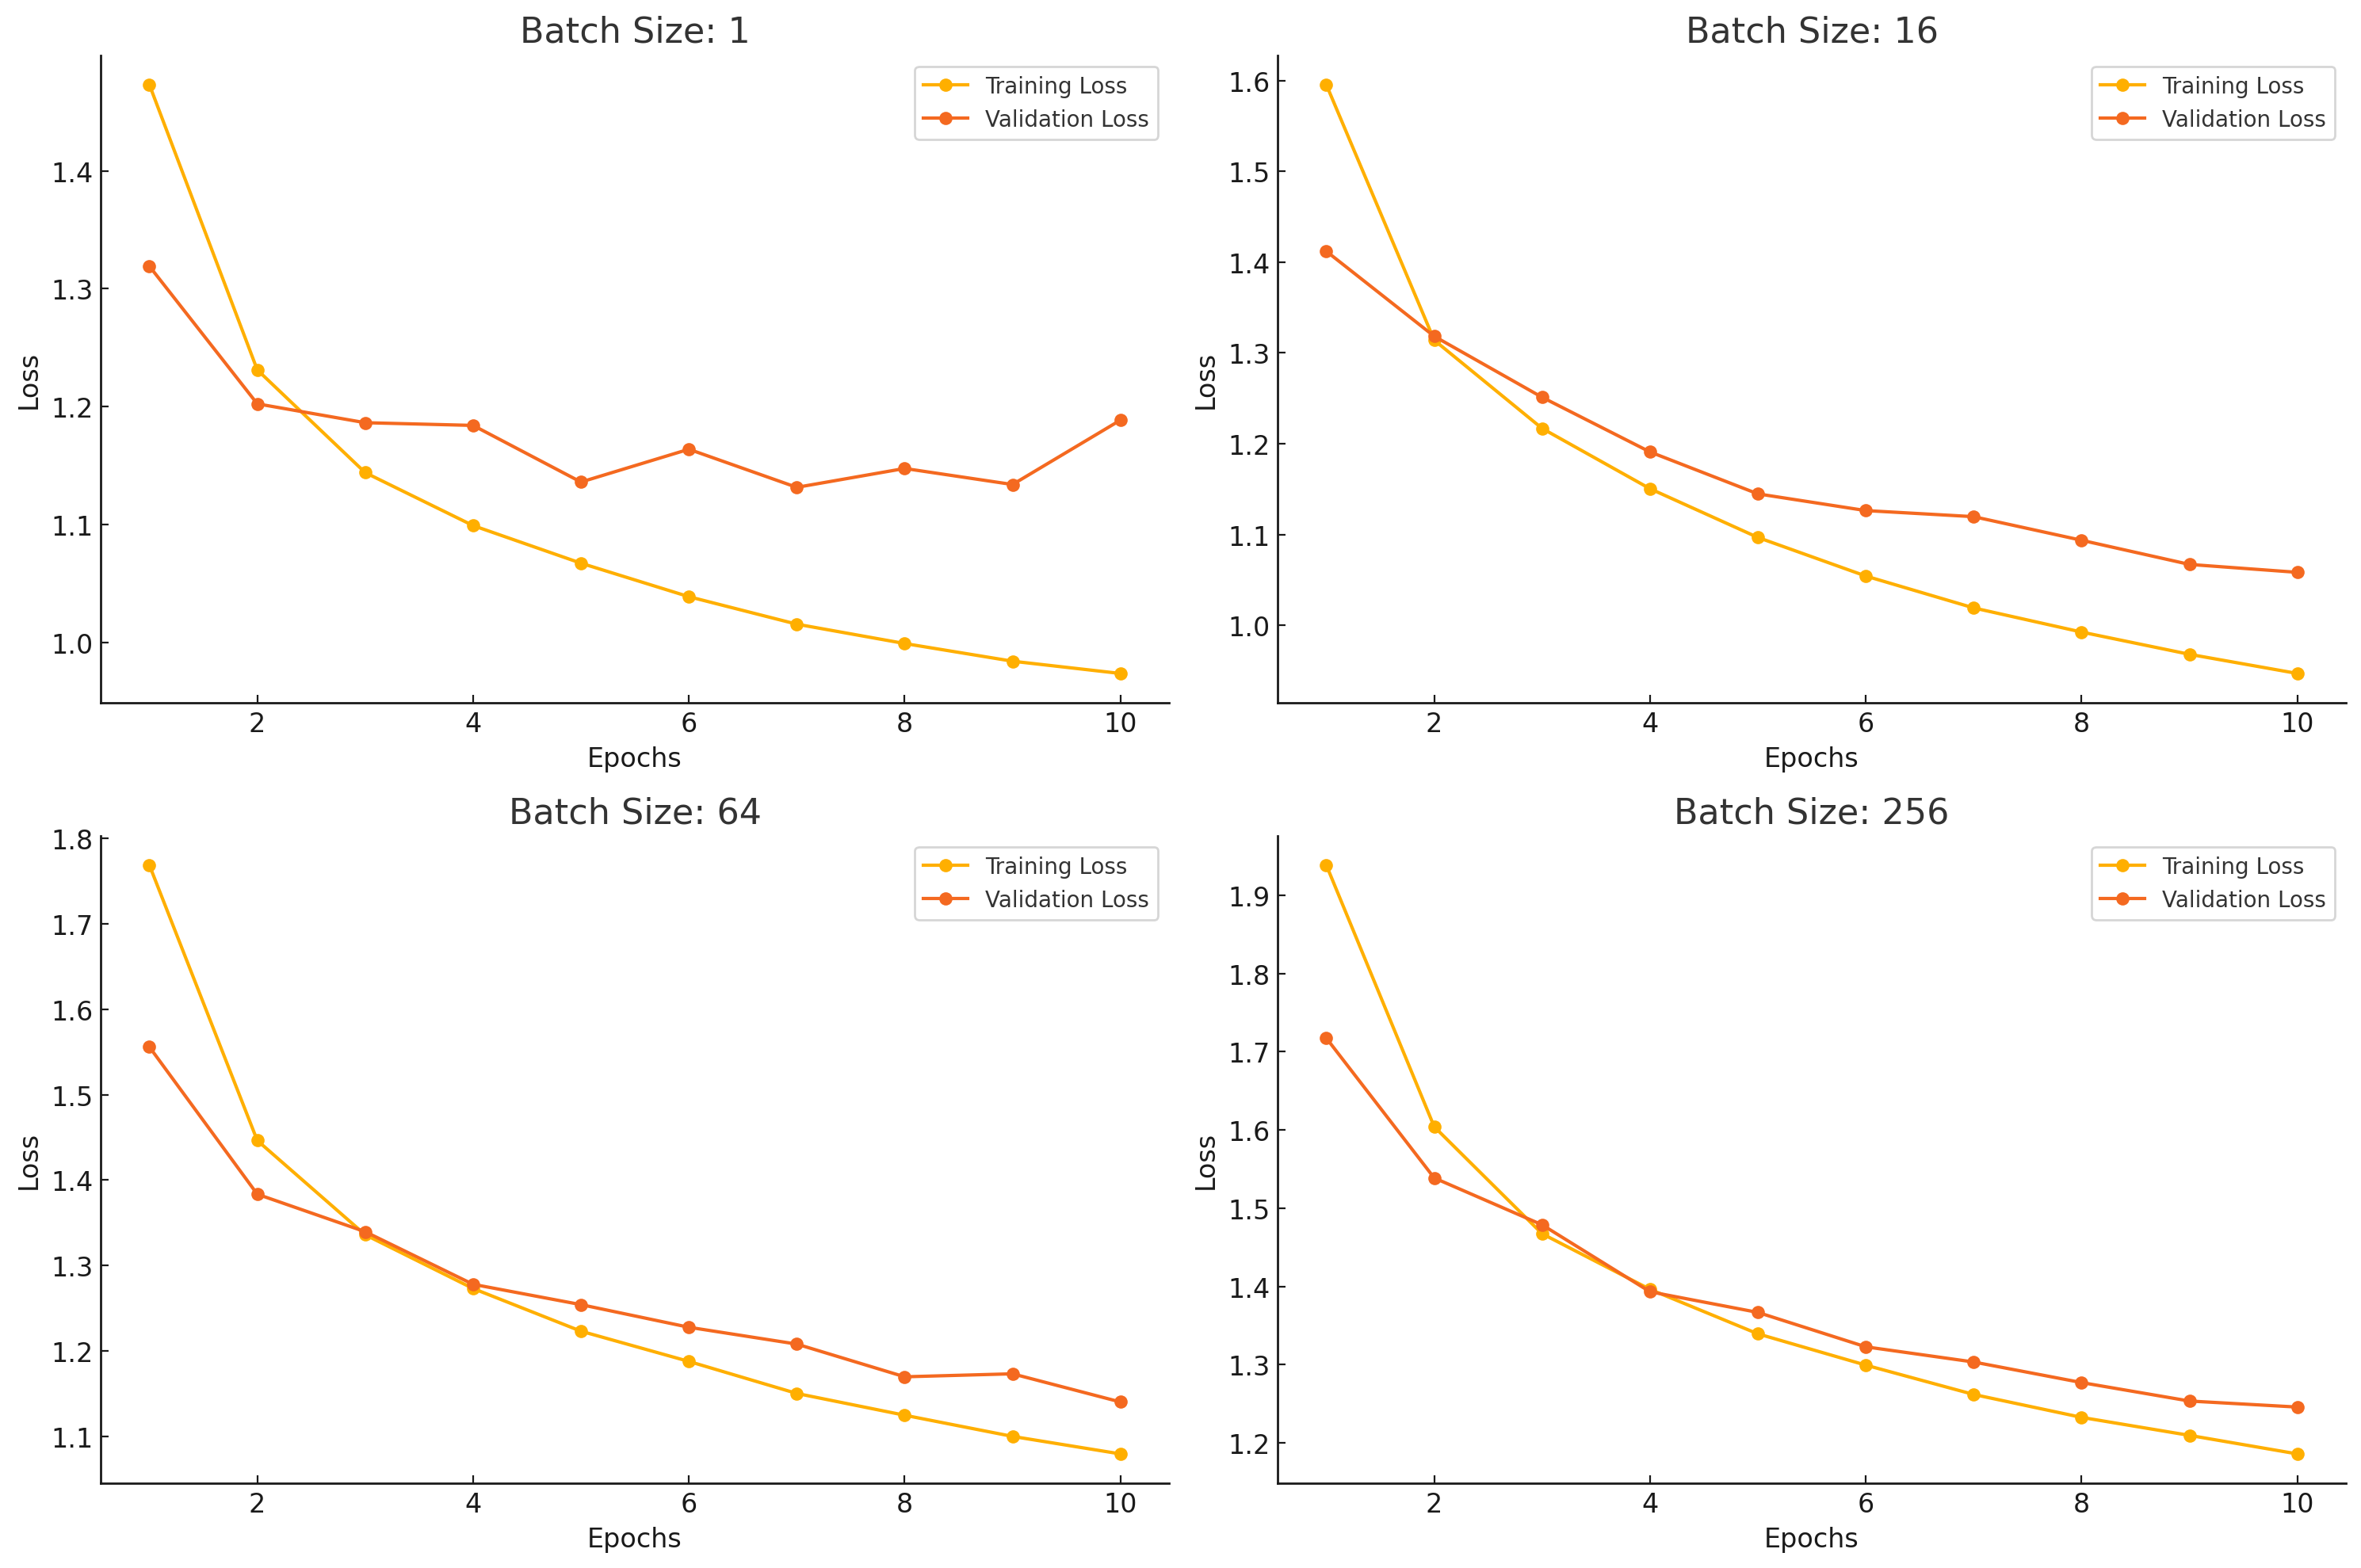

Accuracy Curves: Below are the validation accuracy curves for each batch size. Each plot highlights how the model’s prediction accuracy evolved during the training process.

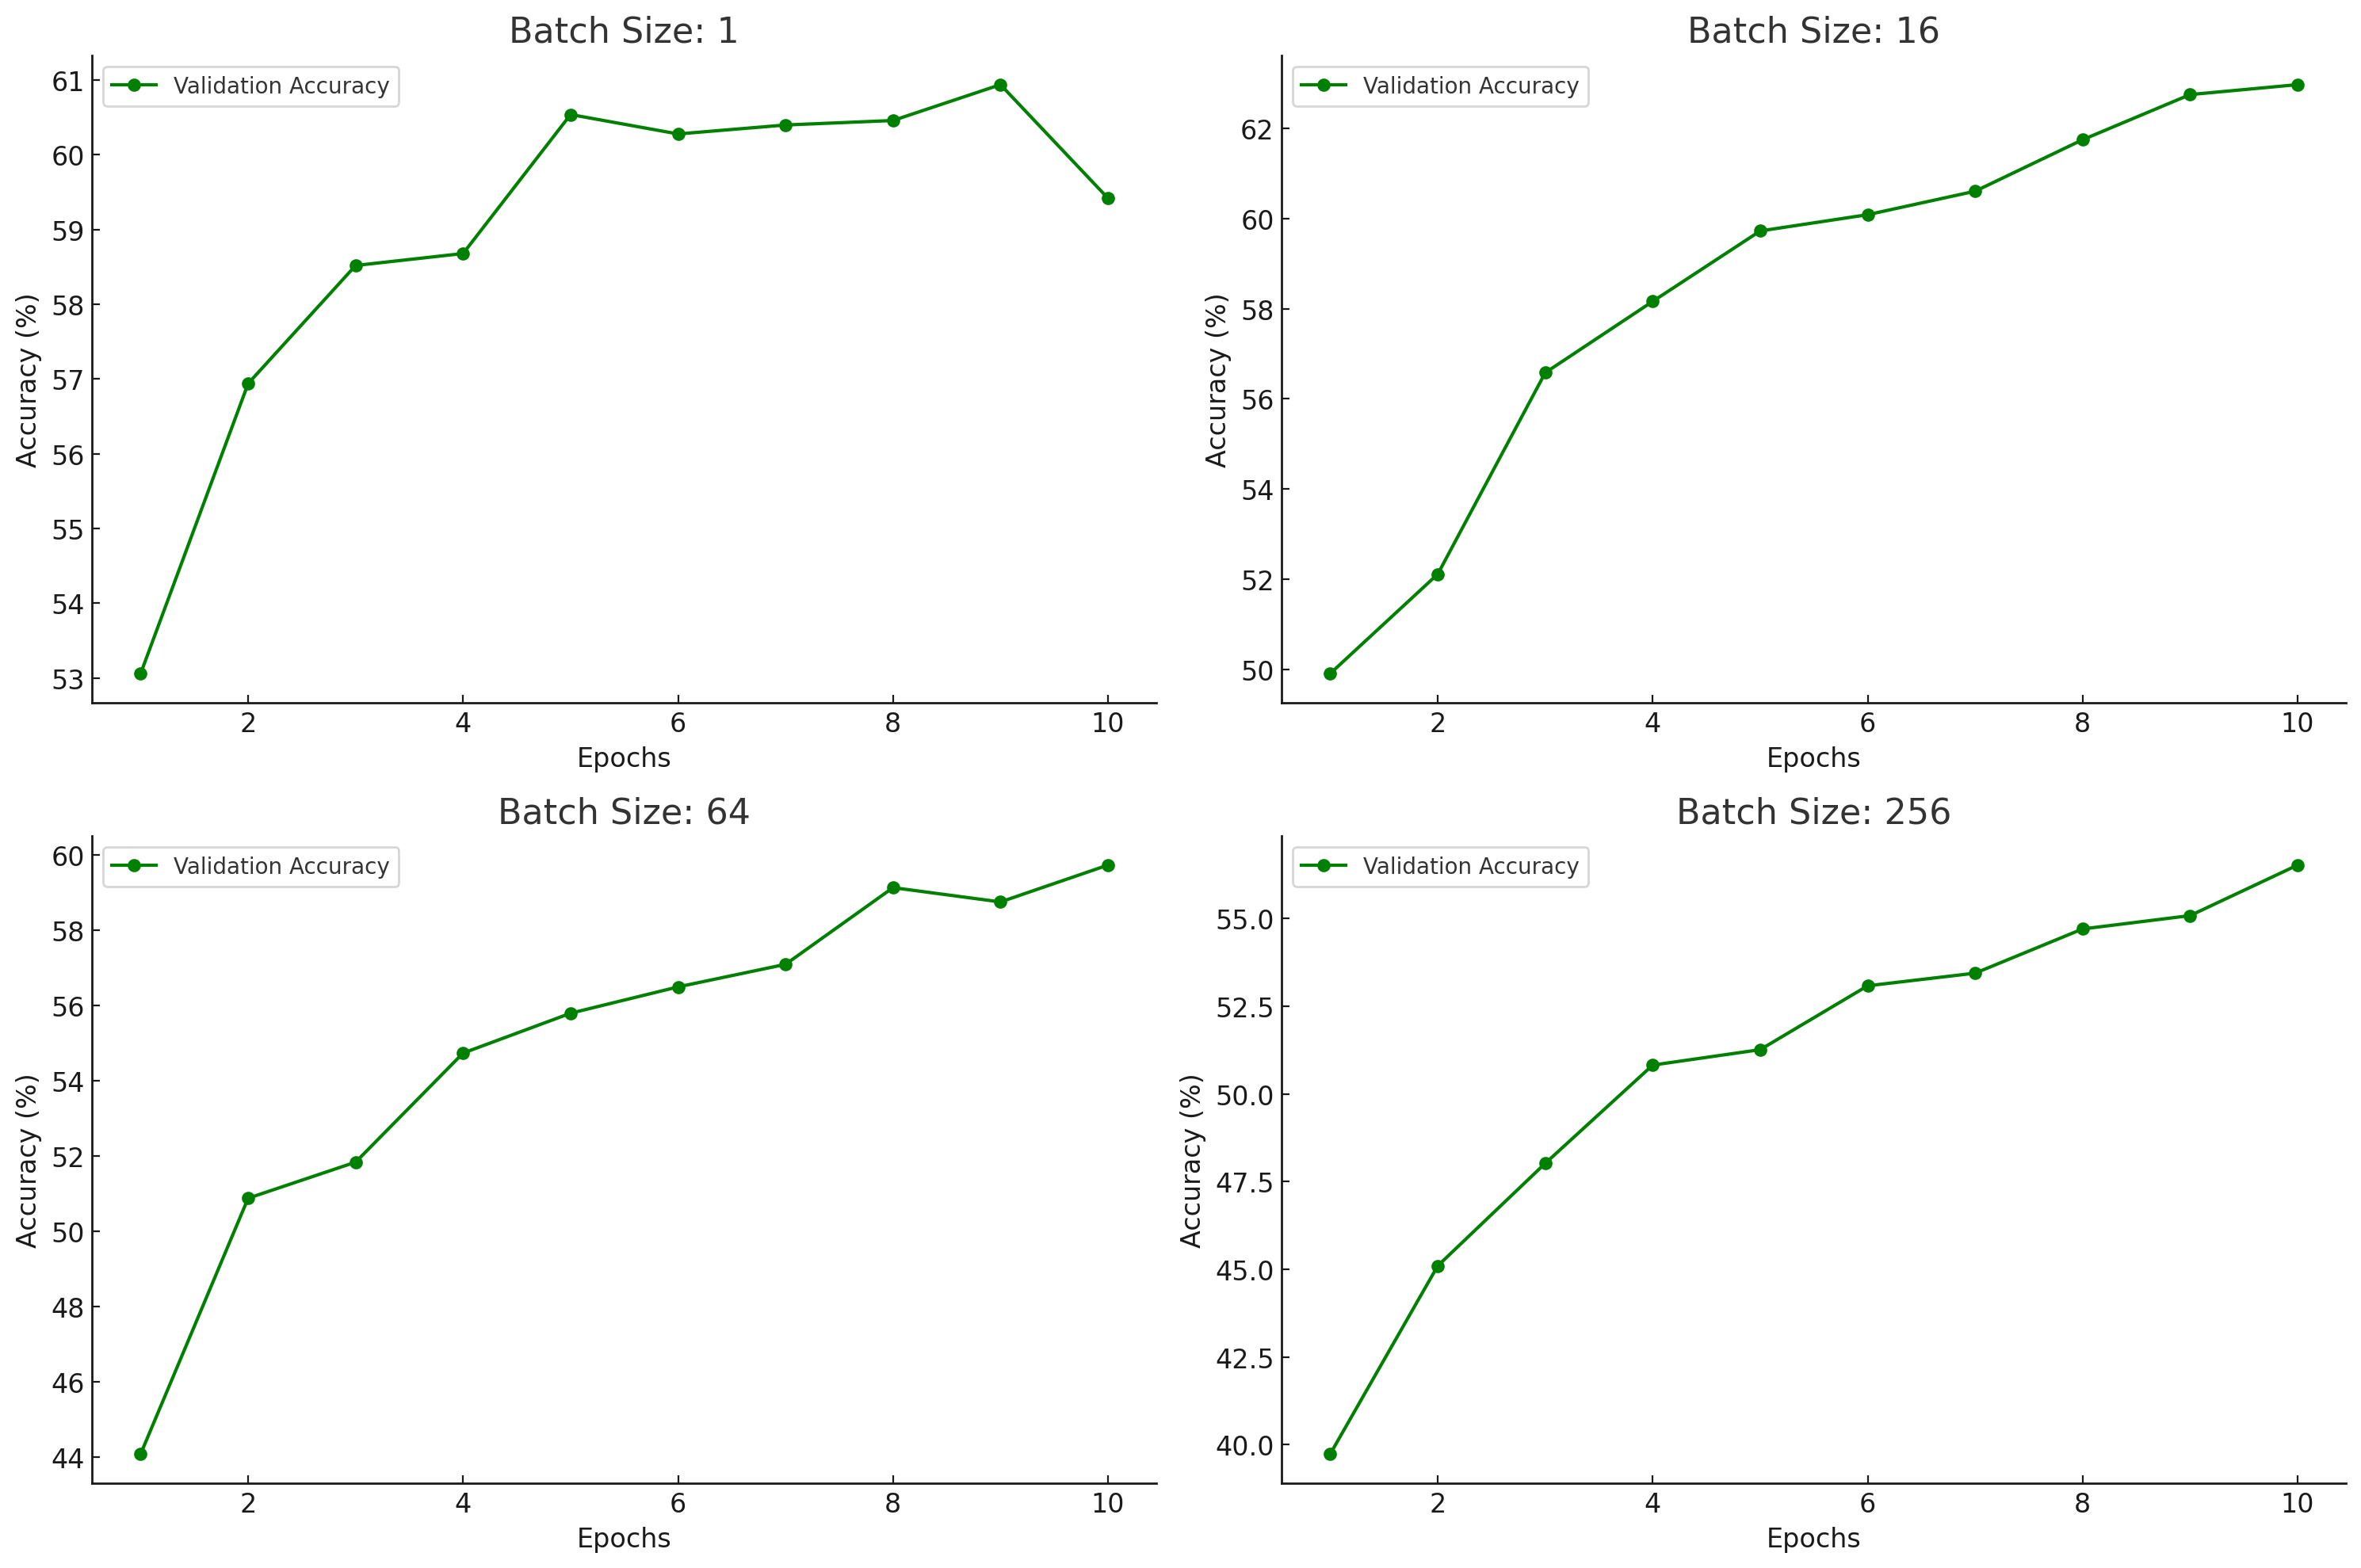

## Observations
* Batch Size 1:
** Training Loss: Decreases steadily but with higher epoch time.
** Validation Accuracy: Peaks at 60.94%, indicating overfitting.
* Batch Size 16:
** Training Loss: Consistently decreases, achieving a balance between stability and speed.
** Validation Accuracy: Highest at 62.96%, suggesting optimal performance among tested batch sizes.
* Batch Size 64:
** Training Loss: Stable decrease but slightly slower convergence.
** Validation Accuracy: Achieves 59.74%, showing decent performance but less optimal than smaller batches.
* Batch Size 256:
** Training Loss: Flatter curves indicating slower convergence.
** Validation Accuracy: Peaks at 56.52%, the lowest among all, due to the large batch’s reduced gradient accuracy.

## Conclusion
* Smaller batch sizes (e.g., 16) provide a good balance between training speed and gradient approximation accuracy.
* Larger batch sizes (e.g., 256) are computationally faster but compromise model performance due to gradient smoothing.
This analysis underscores the importance of tuning batch size for specific applications and datasets to optimize performance.

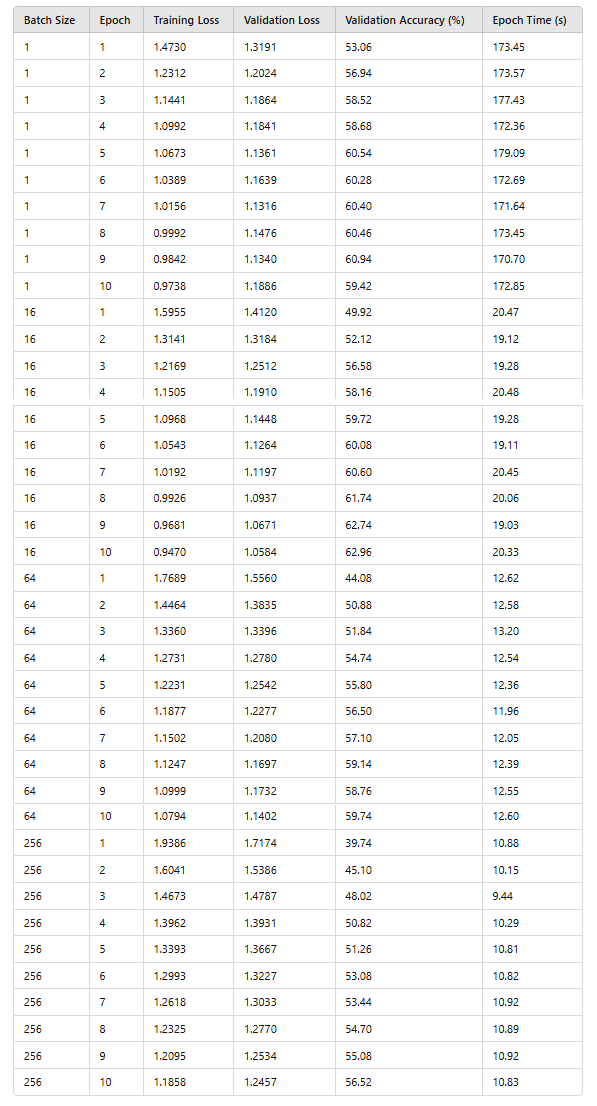

In [ ]:
def train_and_validate_lr(learning_rate, epochs=10):
    # Model setup
    model = CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Learning Rate: {learning_rate}, Epoch {epoch+1}/{epochs}, "
              f"Training Loss: {train_losses[-1]:.4f}, "
              f"Validation Loss: {val_losses[-1]:.4f}, "
              f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, val_accuracies


Experiment with Learning Rate = 0.0001
Learning Rate: 0.0001, Epoch 1/10, Training Loss: 2.1551, Validation Loss: 1.9772, Validation Accuracy: 30.50%
Learning Rate: 0.0001, Epoch 2/10, Training Loss: 1.8903, Validation Loss: 1.8290, Validation Accuracy: 35.74%
Learning Rate: 0.0001, Epoch 3/10, Training Loss: 1.7812, Validation Loss: 1.7498, Validation Accuracy: 37.86%
Learning Rate: 0.0001, Epoch 4/10, Training Loss: 1.7108, Validation Loss: 1.6928, Validation Accuracy: 39.90%
Learning Rate: 0.0001, Epoch 5/10, Training Loss: 1.6572, Validation Loss: 1.6445, Validation Accuracy: 41.52%
Learning Rate: 0.0001, Epoch 6/10, Training Loss: 1.6130, Validation Loss: 1.6074, Validation Accuracy: 42.82%
Learning Rate: 0.0001, Epoch 7/10, Training Loss: 1.5757, Validation Loss: 1.5793, Validation Accuracy: 44.30%
Learning Rate: 0.0001, Epoch 8/10, Training Loss: 1.5453, Validation Loss: 1.5497, Validation Accuracy: 44.80%
Learning Rate: 0.0001, Epoch 9/10, Training Loss: 1.5196, Validation Loss

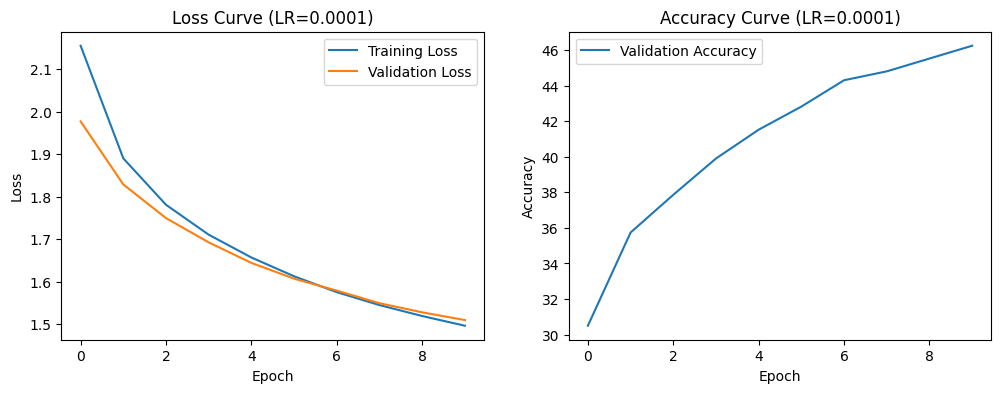

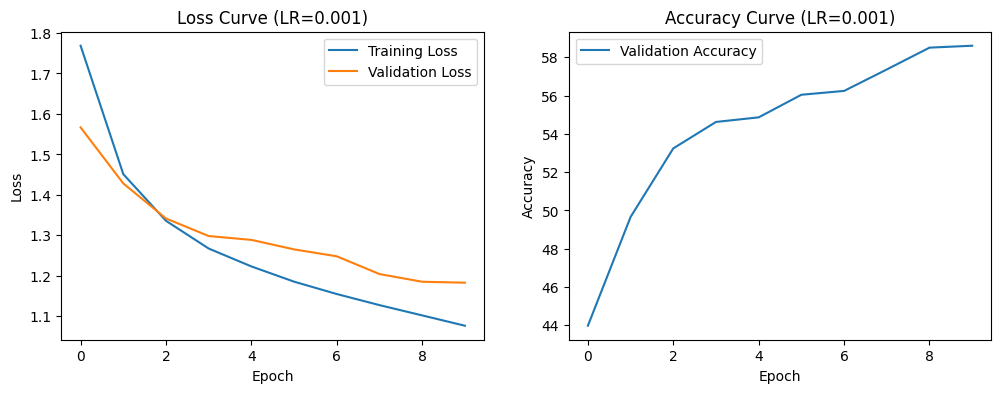

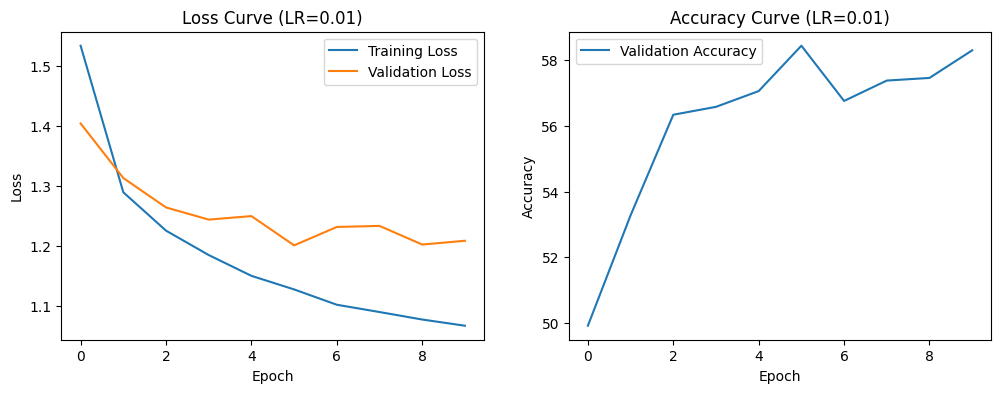

In [ ]:
# Define learning rates to experiment with
learning_rates = [0.0001, 0.001, 0.01]

# Lists to store metrics for each learning rate
train_losses_list = []
val_losses_list = []
val_accuracies_list = []

# Perform training for each learning rate
for lr in learning_rates:
    print(f"Experiment with Learning Rate = {lr}")
    train_losses, val_losses, val_accuracies = train_and_validate_lr(learning_rate=lr, epochs=10)
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    val_accuracies_list.append(val_accuracies)

# Plot the results
def plot_metrics(lrs, train_losses_list, val_losses_list, val_accuracies_list):
    for i, lr in enumerate(lrs):
        plt.figure(figsize=(12, 4))

        # Training and Validation Loss
        plt.subplot(1, 2, 1)
        plt.plot(train_losses_list[i], label='Training Loss')
        plt.plot(val_losses_list[i], label='Validation Loss')
        plt.title(f'Loss Curve (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Validation Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(val_accuracies_list[i], label='Validation Accuracy')
        plt.title(f'Accuracy Curve (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

# Call the plotting function
plot_metrics(learning_rates, train_losses_list, val_losses_list, val_accuracies_list)


# Experimenting with Different Learning Rates
This experiment evaluates the impact of varying learning rates on the performance of a CNN model. Three learning rates were tested: 0.0001, 0.001, and 0.01. The training was conducted over 10 epochs, and metrics such as training loss, validation loss, and validation accuracy were recorded.

## Objective
To determine the optimal learning rate that achieves a balance between training speed and model accuracy.

## Methodology
1. Model Setup: A CNN model was initialized and trained with the Adam optimizer.
2. Learning Rates: The learning rates tested were 0.0001, 0.001, and 0.01.
3. Evaluation Metrics: Training loss, validation loss, and validation accuracy were recorded for comparison.

## Results Summary
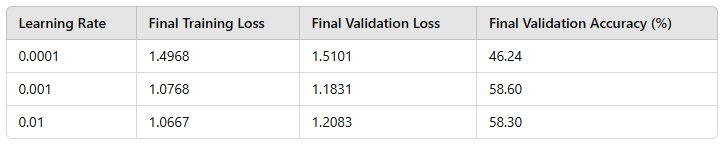

## Observations
* Learning Rate = 0.0001: Converged slowly, with the lowest accuracy (46.24%) among the tested rates.
* Learning Rate = 0.001: Achieved the best balance between training loss, validation loss, and accuracy (58.60%).
* Learning Rate = 0.01: While the training loss was the lowest, the validation accuracy (58.30%) was slightly below that of 0.001, indicating potential overfitting or instability.

## Conclusion
The learning rate of 0.001 is the most optimal for this experiment, providing a good trade-off between loss and accuracy.

In [ ]:
def train_with_scheduler(
    scheduler_type, epochs=20, initial_lr=0.01, patience=3, factor=0.1, milestones=None
):
    # Model setup
    model = CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

    # Scheduler setup
    if scheduler_type == "ReduceLROnPlateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', patience=patience, factor=factor
        )
    elif scheduler_type == "MultiStepLR":
        if milestones is None:
            raise ValueError("Milestones must be provided for MultiStepLR")
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=milestones, gamma=factor
        )
    elif scheduler_type == "LinearLR":
        scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=factor, total_iters=epochs
        )
    else:
        raise ValueError(f"Unsupported scheduler type: {scheduler_type}")

    train_losses = []
    val_losses = []
    val_accuracies = []
    lr_values = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        # Scheduler step
        if scheduler_type == "ReduceLROnPlateau":
            scheduler.step(val_loss)
        else:
            scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        lr_values.append(current_lr)

        print(f"{scheduler_type} | Epoch {epoch+1}/{epochs}, "
              f"LR: {current_lr:.6f}, "
              f"Training Loss: {train_losses[-1]:.4f}, "
              f"Validation Loss: {val_losses[-1]:.4f}, "
              f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, val_accuracies, lr_values


In [ ]:
print("Experiment with ReduceLROnPlateau")
reduce_plateau_results = train_with_scheduler(
    scheduler_type="ReduceLROnPlateau", epochs=15, initial_lr=0.01, patience=3, factor=0.1
)


print("Experiment with MultiStepLR")
multi_step_results = train_with_scheduler(
    scheduler_type="MultiStepLR", epochs=15, initial_lr=0.01, milestones=[10, 15], factor=0.1
)


print("Experiment with LinearLR")
linear_lr_results = train_with_scheduler(
    scheduler_type="LinearLR", epochs=15, initial_lr=0.01
)


Experiment with ReduceLROnPlateau
ReduceLROnPlateau | Epoch 1/15, LR: 0.010000, Training Loss: 1.5494, Validation Loss: 1.3351, Validation Accuracy: 52.54%
ReduceLROnPlateau | Epoch 2/15, LR: 0.010000, Training Loss: 1.2974, Validation Loss: 1.2579, Validation Accuracy: 53.94%
ReduceLROnPlateau | Epoch 3/15, LR: 0.010000, Training Loss: 1.2168, Validation Loss: 1.2108, Validation Accuracy: 57.70%
ReduceLROnPlateau | Epoch 4/15, LR: 0.010000, Training Loss: 1.1703, Validation Loss: 1.1501, Validation Accuracy: 58.94%
ReduceLROnPlateau | Epoch 5/15, LR: 0.010000, Training Loss: 1.1400, Validation Loss: 1.1941, Validation Accuracy: 58.44%
ReduceLROnPlateau | Epoch 6/15, LR: 0.010000, Training Loss: 1.1158, Validation Loss: 1.2216, Validation Accuracy: 57.30%
ReduceLROnPlateau | Epoch 7/15, LR: 0.010000, Training Loss: 1.0923, Validation Loss: 1.1645, Validation Accuracy: 59.30%
ReduceLROnPlateau | Epoch 8/15, LR: 0.010000, Training Loss: 1.0799, Validation Loss: 1.1307, Validation Accurac

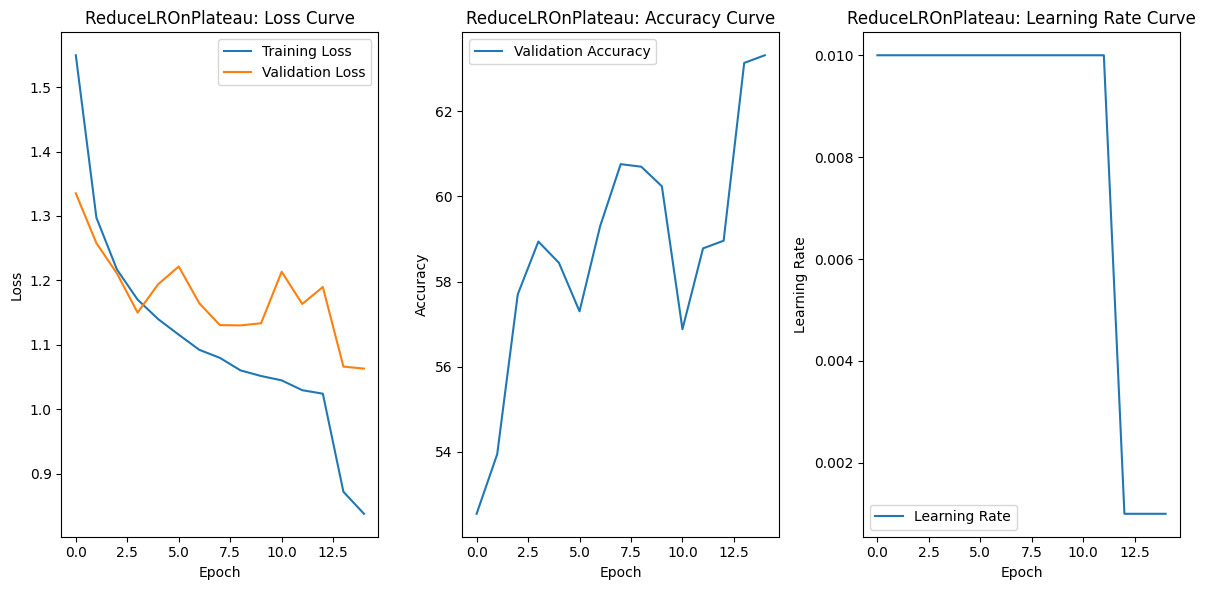

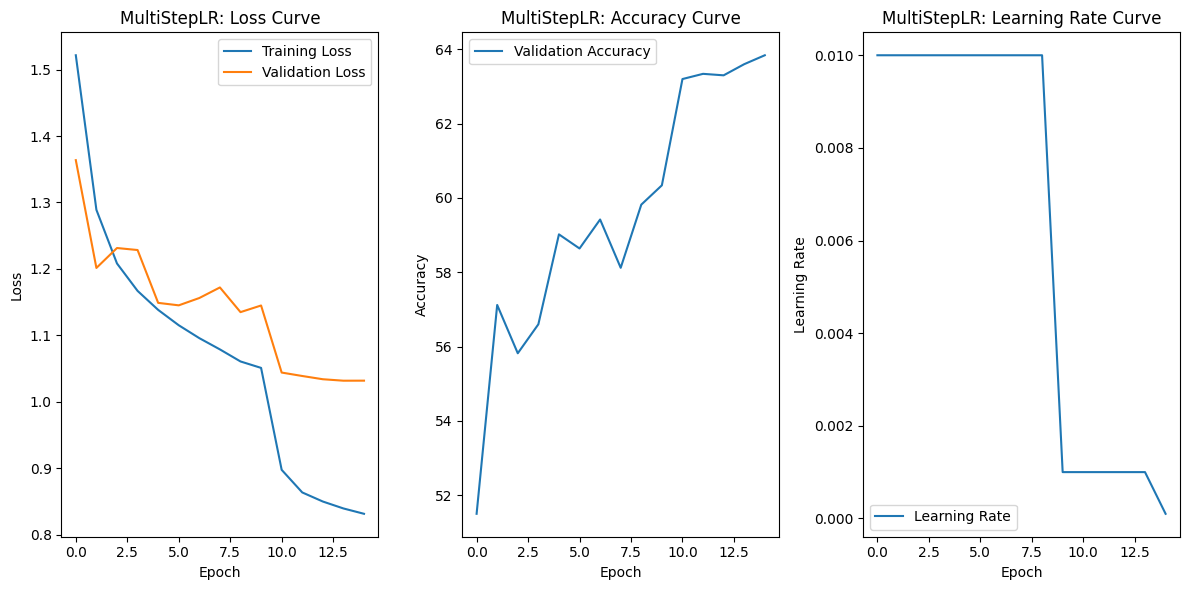

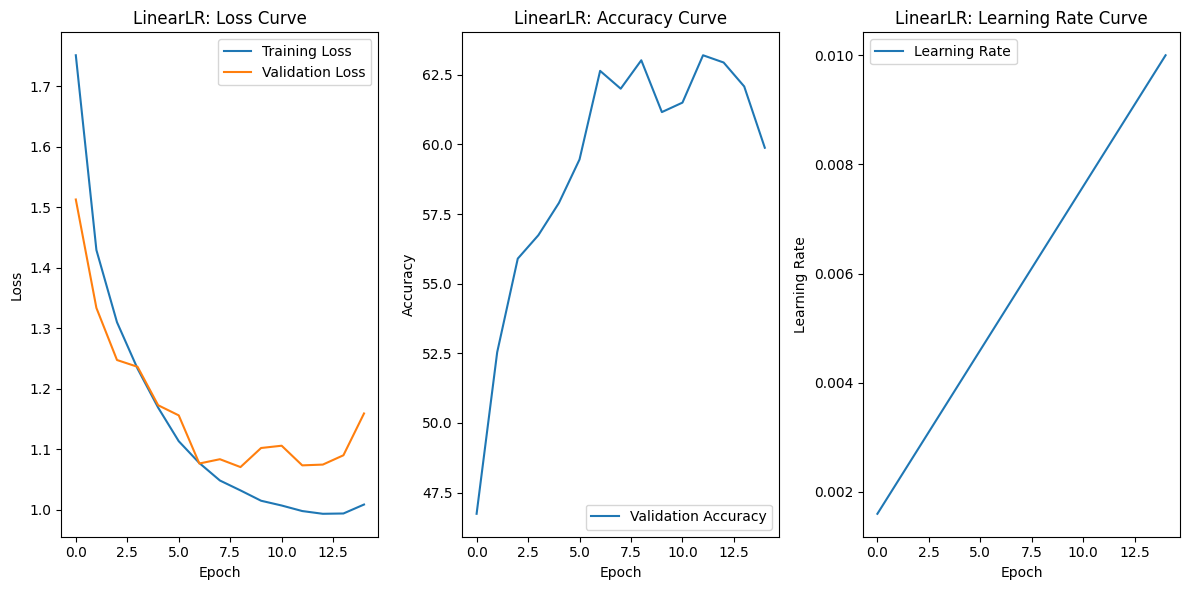

In [ ]:
def plot_scheduler_results(results, scheduler_name):
    train_losses, val_losses, val_accuracies, lr_values = results

    plt.figure(figsize=(12, 6))

    # Loss curves
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{scheduler_name}: Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 3, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'{scheduler_name}: Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Learning rate curve
    plt.subplot(1, 3, 3)
    plt.plot(lr_values, label='Learning Rate')
    plt.title(f'{scheduler_name}: Learning Rate Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot results for each scheduler
plot_scheduler_results(reduce_plateau_results, "ReduceLROnPlateau")
plot_scheduler_results(multi_step_results, "MultiStepLR")
plot_scheduler_results(linear_lr_results, "LinearLR")


## Experimenting with Learning Rate Schedulers
This experiment compares the performance of three learning rate schedulers in training a CNN model: ReduceLROnPlateau, MultiStepLR, and LinearLR. The goal is to determine the impact of each scheduler on model performance over 15 epochs.

## Objective
To evaluate the effectiveness of different learning rate schedulers in improving the training process of a CNN model on a given dataset.

## Learning Rate Schedulers
1. ReduceLROnPlateau: Reduces the learning rate when the validation loss stagnates for a specified number of epochs.
2. MultiStepLR: Reduces the learning rate at predefined epochs (milestones).
3. LinearLR: Adjusts the learning rate linearly over a specified number of epochs.

## Results Summary
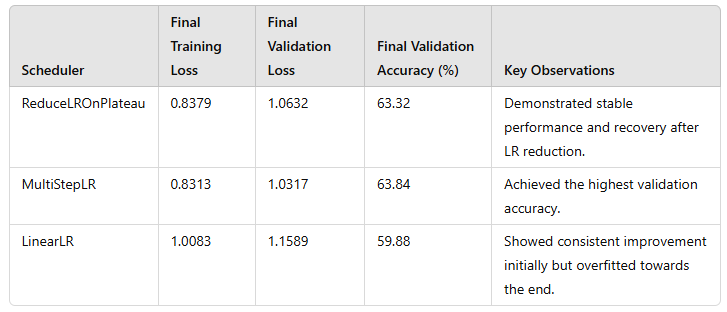

## Observations
1. ReduceLROnPlateau:
* Adjusted the learning rate dynamically based on validation loss stagnation.
* Resulted in smooth training and good final performance.
2. MultiStepLR:
* Predefined learning rate reductions improved performance significantly after milestones.
* Achieved the best final validation accuracy (63.84%).
3. LinearLR:
* Gradually increased learning rate, which worked well in the early epochs.
* However, the model seemed to overfit towards the later epochs, as the validation accuracy declined.

## Conclusion
* MultiStepLR delivered the best overall performance in terms of final accuracy and validation loss.
* ReduceLROnPlateau is effective for dynamic adjustments and is robust to training fluctuations.
* LinearLR is less suitable for this scenario as the gradually increasing learning rate led to overfitting.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 dataset with basic preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ResNet and DenseNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

# Load CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Split dataset into train (70%), validation (10%), and test (20%)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, _ = random_split(dataset, [train_size, val_size, test_size])

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Load pre-trained models
resnet_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
densenet_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# Modify the final layers for CIFAR-10 classification
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 10)

# Move models to device
resnet_model = resnet_model.to(device)
densenet_model = densenet_model.to(device)

# Function to evaluate model and measure memory usage
def evaluate_memory_and_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    # Clear GPU memory
    torch.cuda.empty_cache()

    # Measure memory before evaluation
    torch.cuda.reset_peak_memory_stats(device)

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Measure peak memory used
    peak_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # Convert to MB
    accuracy = 100 * correct / total
    return accuracy, peak_memory

# Evaluate ResNet18
resnet_accuracy, resnet_memory = evaluate_memory_and_accuracy(resnet_model, test_loader)
print(f"ResNet18 Accuracy (no fine-tuning): {resnet_accuracy:.2f}%")
print(f"ResNet18 Peak GPU Memory Usage: {resnet_memory:.2f} MB")

# Evaluate DenseNet121
densenet_accuracy, densenet_memory = evaluate_memory_and_accuracy(densenet_model, test_loader)
print(f"DenseNet121 Accuracy (no fine-tuning): {densenet_accuracy:.2f}%")
print(f"DenseNet121 Peak GPU Memory Usage: {densenet_memory:.2f} MB")


Files already downloaded and verified
Files already downloaded and verified
ResNet18 Accuracy (no fine-tuning): 10.35%
ResNet18 Peak GPU Memory Usage: 751.88 MB
DenseNet121 Accuracy (no fine-tuning): 9.90%
DenseNet121 Peak GPU Memory Usage: 1002.07 MB


# Transfer Learning
## Objective
To evaluate the performance of pre-trained ResNet18 and DenseNet121 models on the CIFAR-10 dataset without fine-tuning the weights. Performance is compared with the previously best model based on accuracy and GPU memory usage.

## Dataset and Preprocessing
* Dataset Used: CIFAR-10, consisting of 60,000 32x32 images in 10 classes.
* Preprocessing Steps:
** Images resized to 224×224 pixels for compatibility with ResNet and DenseNet models.
** Normalized using mean = [0.485 , 0.456 , 0.406] and std = [0.229,0.224,0.225] to match pre-trained model requirements.

## Model Details
1. ResNet18:
* Pre-trained on the ImageNet dataset.
* Final fully connected layer replaced with a linear layer having 10 output features (corresponding to CIFAR-10 classes).

2. DenseNet121:
* Pre-trained on the ImageNet dataset.
* Classifier layer replaced with a linear layer having 10 output features.

## Evaluation Metrics
* Accuracy: The percentage of correctly classified test samples.
* Peak GPU Memory Usage: Maximum GPU memory allocated during model evaluation, measured in MB.

# Results
The results of the evaluation without fine-tuning are as follows:
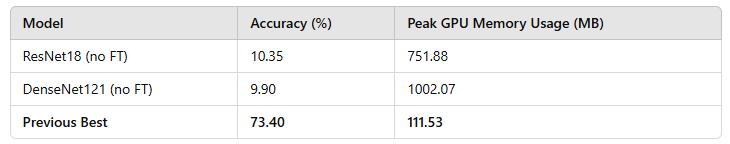

## Analysis
1. Accuracy:

* The pre-trained ResNet18 and DenseNet121 models show significantly low accuracy(≈10%) when directly applied to CIFAR-10 without weight fine-tuning.
* This is expected, as the models are optimized for ImageNet, a dataset with a larger and different set of categories compared to CIFAR-10.

2. Memory Usage:
* ResNet18 consumes 25% less memory compared to DenseNet121.
* Both models use substantially more GPU memory compared to the previous best model, indicating the heavier architecture and increased parameters.

3. Comparison with Previous Best Model:
* The previous best model outperforms ResNet18 and DenseNet121 in terms of accuracy (by 63% or more) and memory efficiency.
* This highlights the necessity of fine-tuning or transfer learning to adapt pre-trained models to new tasks.

## Conclusion
While pre-trained ResNet18 and DenseNet121 provide a starting point for transfer learning, they are not directly effective for classifying CIFAR-10 images without fine-tuning. DenseNet121 offers slightly lower accuracy than ResNet18 while consuming significantly more GPU memory. Fine-tuning these models in the next step will be essential to achieve better performance.

100%|██████████| 170M/170M [00:05<00:00, 31.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 133MB/s]



Fine-tuning ResNet18:
Epoch [1/10], Loss: 950.1584, Val Loss: 99.8394, Val Accuracy: 67.30%
Epoch [2/10], Loss: 599.9672, Val Loss: 75.0604, Val Accuracy: 73.10%
Epoch [3/10], Loss: 489.3754, Val Loss: 64.7120, Val Accuracy: 75.42%
Epoch [4/10], Loss: 454.0607, Val Loss: 63.7002, Val Accuracy: 75.74%
Epoch [5/10], Loss: 449.4404, Val Loss: 63.4512, Val Accuracy: 75.78%
Epoch [6/10], Loss: 445.4185, Val Loss: 62.8394, Val Accuracy: 75.90%
Epoch [7/10], Loss: 441.7499, Val Loss: 62.6568, Val Accuracy: 76.12%
Epoch [8/10], Loss: 441.8872, Val Loss: 62.6411, Val Accuracy: 76.16%
Epoch [9/10], Loss: 440.4601, Val Loss: 62.5615, Val Accuracy: 75.90%
Epoch [10/10], Loss: 440.1294, Val Loss: 62.6420, Val Accuracy: 75.88%
Training Time: 793.00 seconds

Fine-tuning DenseNet121:
Epoch [1/10], Loss: 906.8097, Val Loss: 94.4634, Val Accuracy: 71.56%
Epoch [2/10], Loss: 569.7900, Val Loss: 71.2397, Val Accuracy: 76.28%
Epoch [3/10], Loss: 463.0106, Val Loss: 61.5467, Val Accuracy: 77.80%
Epoch [4/1

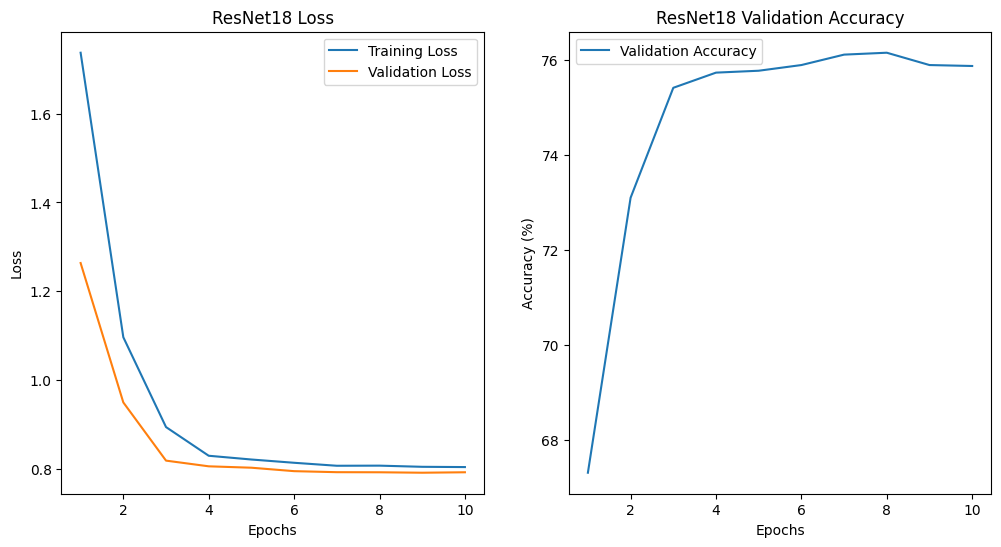

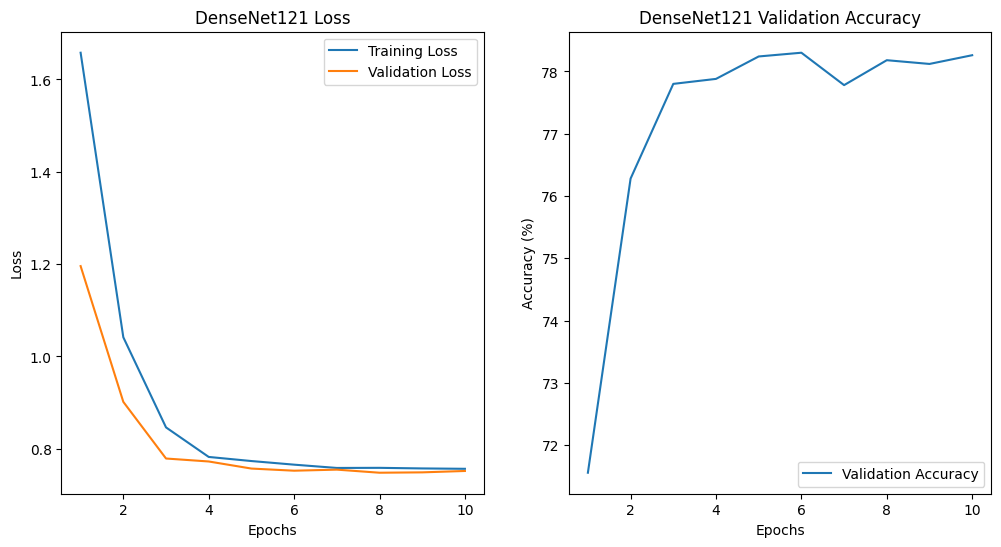


ResNet18 Test Accuracy (Fine-Tuned): 75.90%
DenseNet121 Test Accuracy (Fine-Tuned): 78.43%
ResNet18 Training Time: 793.00 seconds
DenseNet121 Training Time: 1507.43 seconds


In [2]:
import time
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 dataset preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for pre-trained models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Load CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Split dataset into train (70%), validation (10%), and test (20%)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, _ = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Function to train and evaluate a model
def train_and_evaluate(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4, freeze_features=True):
    if freeze_features:
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze only the classifier layers
        if isinstance(model, models.ResNet):
            for param in model.fc.parameters():
                param.requires_grad = True
        elif isinstance(model, models.DenseNet):
            for param in model.classifier.parameters():
                param.requires_grad = True

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    # Scheduler for learning rate adjustment
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Track metrics
    train_losses = []
    val_losses = []
    val_accuracies = []
    start_time = time.time()

    # Training loop
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracies.append(100 * correct / total)
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

        scheduler.step()

    elapsed_time = time.time() - start_time
    print(f"Training Time: {elapsed_time:.2f} seconds")
    return model, train_losses, val_losses, val_accuracies, elapsed_time

# Load pre-trained models
resnet_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
densenet_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# Modify the final layers for CIFAR-10 classification
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 10)

# Fine-tune the ResNet model
print("\nFine-tuning ResNet18:")
fine_tuned_resnet, resnet_train_losses, resnet_val_losses, resnet_val_accuracies, resnet_time = train_and_evaluate(
    resnet_model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4)

# Fine-tune the DenseNet model
print("\nFine-tuning DenseNet121:")
fine_tuned_densenet, densenet_train_losses, densenet_val_losses, densenet_val_accuracies, densenet_time = train_and_evaluate(
    densenet_model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4)

# Plot training and validation loss
def plot_metrics(train_losses, val_losses, val_accuracies, title):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title(f'{title} Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

plot_metrics(resnet_train_losses, resnet_val_losses, resnet_val_accuracies, 'ResNet18')
plot_metrics(densenet_train_losses, densenet_val_losses, densenet_val_accuracies, 'DenseNet121')

# Evaluate fine-tuned models on the test set
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

resnet_test_accuracy = evaluate_model(fine_tuned_resnet, test_loader)
densenet_test_accuracy = evaluate_model(fine_tuned_densenet, test_loader)

print(f"\nResNet18 Test Accuracy (Fine-Tuned): {resnet_test_accuracy:.2f}%")
print(f"DenseNet121 Test Accuracy (Fine-Tuned): {densenet_test_accuracy:.2f}%")
print(f"ResNet18 Training Time: {resnet_time:.2f} seconds")
print(f"DenseNet121 Training Time: {densenet_time:.2f} seconds")


# Fine-Tuning
## Key Observations:

1. Accuracy Improvement:
* ResNet18 Fine-Tuned:
** Final Validation Accuracy: 76.16%
** Test Accuracy: 75.90%
* DenseNet121 Fine-Tuned:
** Final Validation Accuracy: 78.26%
** Test Accuracy: 78.43%
* Previous Model:
** Final Validation Accuracy: 73.40%

Insight: Both fine-tuned models exhibit a noticeable improvement in validation and test accuracy compared to your previous model.

2. Speed of Convergence:
* ResNet18 and DenseNet121 show strong validation accuracy within the first few epochs:
** ResNet18 reaches 75.42% by epoch 3.
** DenseNet121 achieves 77.80% by epoch 3.

* The previous model required 6-7 epochs to achieve comparable accuracy levels (~72.46%).

Insight: Pre-trained models converge faster due to their pre-learned feature representations.

3. Loss Trends:
* ResNet18 and DenseNet121 fine-tuned models maintain steady and consistent validation loss throughout training, indicating that overfitting is well-controlled.
* The previous model exhibits increasing validation loss after epoch 3, suggesting overfitting.

4. Training Time:
* ResNet18: 793 seconds (13.2 minutes)
* DenseNet121: 1507 seconds (25.1 minutes)
* Previous model: Training time was not explicitly recorded, but the time efficiency of fine-tuning varies significantly between ResNet18 and DenseNet121 due to their architecture complexities.

## Comparison Table:
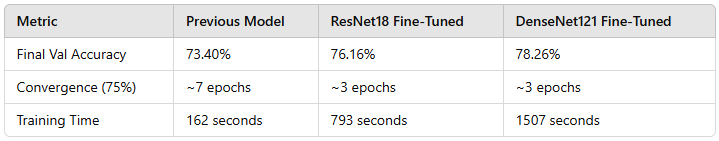

# Transfer Learning and Weight Tuning
Transfer learning is a machine learning technique where a pre-trained model, trained on a large dataset (e.g., ImageNet), is adapted to solve a different but related task. Instead of training a model from scratch, transfer learning leverages the pre-trained model's learned features, significantly reducing computational effort and training time.

## Steps in Transfer Learning
1. Load a Pre-Trained Model:

* Models like ResNet, DenseNet, and VGG are often pre-trained on large-scale datasets such as ImageNet.
* These models have already learned generic features (e.g., edges, textures, patterns) in their earlier layers and more task-specific features in their deeper layers.

2. Adapt the Model:
* Adjust the final layers of the pre-trained model to fit the new task (e.g., classification of 10 classes in CIFAR-10 instead of 1,000 classes in ImageNet).
* For instance:
** Replace ResNet's fully connected (fc) layer with a layer of size matching the number of classes in the target dataset.
* Replace DenseNet’s classifier layer similarly.

3. Freeze or Fine-Tune Layers:
* Freezing Layers:
** The initial layers are frozen (weights are not updated) to retain the learned features.
** This reduces the risk of overfitting, especially when the target dataset is small.
* Fine-Tuning Layers:
** Some or all layers are unfrozen, allowing weights to adjust to the new dataset.
** Fine-tuning requires a smaller learning rate to avoid disrupting the pre-trained weights.

4. Train the Model on the Target Dataset:
* Train the new model with the target dataset.
* Optimizers like Adam or SGD are used, often with learning rate schedulers to control learning rates dynamically.

## Weight Tuning Process
Weight tuning involves adapting the weights of the pre-trained model during training for the new task. It can be done in the following ways:

1. Freeze All Pre-Trained Layers:

* Train only the new layers added for the target task.
* This is quick and effective if the target dataset is small or similar to the dataset used for pre-training.

2. Freeze Some Layers and Fine-Tune the Rest:
* Freeze the lower layers (generic features) and fine-tune the higher layers (task-specific features).
* This is useful when the target dataset is moderately different from the pre-trained dataset.

3. Fine-Tune All Layers:
* Unfreeze all layers and fine-tune the entire model.
* This approach requires more data and computational resources but allows the model to adapt completely to the new dataset.

## Advantages of Transfer Learning
1. Faster Convergence:
* The model starts with pre-trained weights, allowing it to converge quickly compared to training from scratch.
2. Reduced Data Requirement:
* The pre-trained model has already learned robust features, requiring less data for fine-tuning.
3. Improved Accuracy:
* The model benefits from features learned on large-scale datasets, leading to better performance on related tasks.
4. Computational Efficiency:
* Less training time and resources are needed as only a subset of layers might be trained.

Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 168MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 123MB/s]



Fine-tuning ResNet18:
Epoch [1/10], Loss: 915.2166, Val Loss: 96.2959, Val Accuracy: 68.66%
Epoch [2/10], Loss: 584.7994, Val Loss: 73.5417, Val Accuracy: 73.04%
Epoch [3/10], Loss: 482.3341, Val Loss: 64.3241, Val Accuracy: 75.18%
Epoch [4/10], Loss: 449.0542, Val Loss: 63.6588, Val Accuracy: 75.68%
Epoch [5/10], Loss: 445.0014, Val Loss: 63.2288, Val Accuracy: 75.42%
Epoch [6/10], Loss: 440.0340, Val Loss: 62.5606, Val Accuracy: 75.36%
Epoch [7/10], Loss: 438.3813, Val Loss: 62.1744, Val Accuracy: 75.62%
Epoch [8/10], Loss: 437.2615, Val Loss: 62.4679, Val Accuracy: 75.58%
Epoch [9/10], Loss: 435.9048, Val Loss: 62.1789, Val Accuracy: 75.68%
Epoch [10/10], Loss: 436.2678, Val Loss: 62.2490, Val Accuracy: 75.62%
Training Time: 790.16 seconds

Fine-tuning ResNet34:
Epoch [1/10], Loss: 923.2828, Val Loss: 96.4651, Val Accuracy: 68.60%
Epoch [2/10], Loss: 574.6540, Val Loss: 72.5749, Val Accuracy: 74.50%
Epoch [3/10], Loss: 468.5602, Val Loss: 62.5389, Val Accuracy: 76.94%
Epoch [4/10],

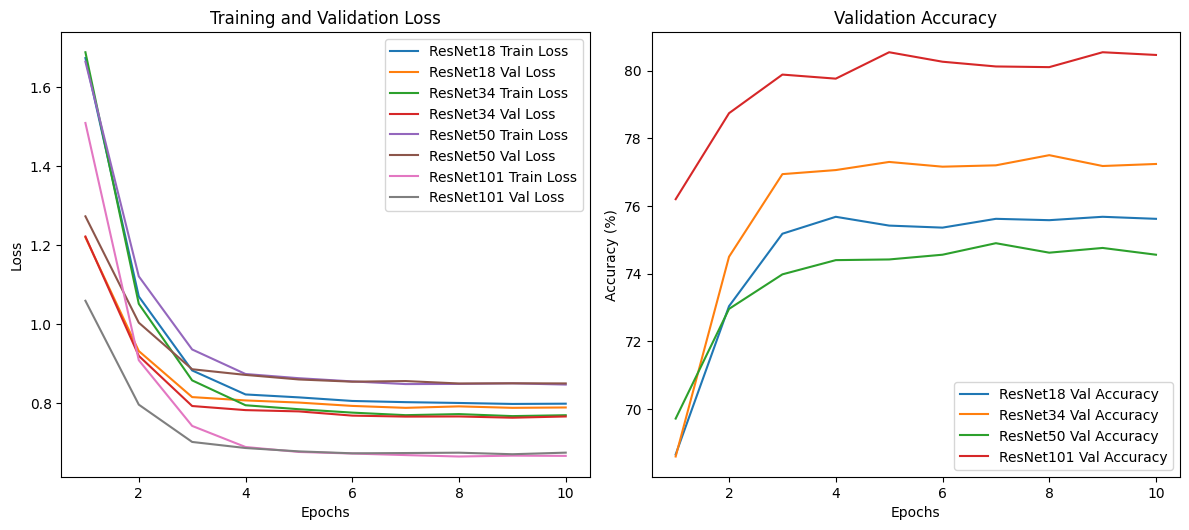

ResNet18 Test Accuracy (Fine-Tuned): 75.73%
ResNet18 Training Time: 790.16 seconds
ResNet34 Test Accuracy (Fine-Tuned): 76.91%
ResNet34 Training Time: 908.14 seconds
ResNet50 Test Accuracy (Fine-Tuned): 75.49%
ResNet50 Training Time: 1347.77 seconds
ResNet101 Test Accuracy (Fine-Tuned): 80.91%
ResNet101 Training Time: 2128.10 seconds


In [3]:
import time
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 dataset preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for pre-trained models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Load CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Split dataset into train (70%), validation (10%), and test (20%)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, _ = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Function to train and evaluate a model
def train_and_evaluate(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4, freeze_features=True):
    if freeze_features:
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze only the classifier layers
        if isinstance(model, models.ResNet):
            for param in model.fc.parameters():
                param.requires_grad = True

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    # Scheduler for learning rate adjustment
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Track metrics
    train_losses = []
    val_losses = []
    val_accuracies = []
    start_time = time.time()

    # Training loop
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracies.append(100 * correct / total)
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

        scheduler.step()

    elapsed_time = time.time() - start_time
    print(f"Training Time: {elapsed_time:.2f} seconds")
    return model, train_losses, val_losses, val_accuracies, elapsed_time

# Load different ResNet models with varying depths
resnet_models = {
    'ResNet18': models.resnet18(weights=models.ResNet18_Weights.DEFAULT),
    'ResNet34': models.resnet34(weights=models.ResNet34_Weights.DEFAULT),
    'ResNet50': models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
    'ResNet101': models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
}

# Modify the final layers for CIFAR-10 classification
for model in resnet_models.values():
    model.fc = nn.Linear(model.fc.in_features, 10)

# Fine-tune each ResNet model and record the results
results = {}

for model_name, model in resnet_models.items():
    print(f"\nFine-tuning {model_name}:")
    fine_tuned_model, train_losses, val_losses, val_accuracies, elapsed_time = train_and_evaluate(
        model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4
    )
    results[model_name] = {
        'model': fine_tuned_model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'elapsed_time': elapsed_time
    }

# Plot training and validation loss for each model
def plot_metrics_for_models(results):
    epochs = range(1, len(results['ResNet18']['train_losses']) + 1)
    plt.figure(figsize=(12, 10))

    for model_name, result in results.items():
        train_losses = result['train_losses']
        val_losses = result['val_losses']
        val_accuracies = result['val_accuracies']

        # Loss plot
        plt.subplot(2, 2, 1)
        plt.plot(epochs, train_losses, label=f'{model_name} Train Loss')
        plt.plot(epochs, val_losses, label=f'{model_name} Val Loss')

        # Accuracy plot
        plt.subplot(2, 2, 2)
        plt.plot(epochs, val_accuracies, label=f'{model_name} Val Accuracy')

    plt.subplot(2, 2, 1)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics_for_models(results)

# Evaluate each fine-tuned ResNet model on the test set and display results
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

for model_name, result in results.items():
    test_accuracy = evaluate_model(result['model'], test_loader)
    print(f"{model_name} Test Accuracy (Fine-Tuned): {test_accuracy:.2f}%")
    print(f"{model_name} Training Time: {result['elapsed_time']:.2f} seconds")


# Observations:
1. Accuracy Trends:
* ResNet101 achieves the highest test accuracy (80.91%) and validation accuracy during training (80.54%).
* ResNet34 shows competitive performance with a test accuracy of 76.91%, outperforming both ResNet18 and ResNet50 despite its lower complexity compared to ResNet50.
* ResNet18 has the lowest test accuracy (75.73%), as expected given its shallower architecture and fewer trainable parameters.
* ResNet50 does not improve accuracy significantly compared to ResNet34, indicating diminishing returns from increased depth without optimizing other aspects.

2. Training Time:
* Training time increases with the depth of the models. ResNet101 takes the longest (2128.10 seconds), followed by ResNet50 (1347.77 seconds), ResNet34 (908.14 seconds), and ResNet18 (790.16 seconds).
* The additional complexity of deeper networks translates into longer training times, highlighting the trade-off between performance and computational cost.

3. Validation Loss and Accuracy:
* All models exhibit decreasing validation loss over epochs, suggesting effective learning. ResNet101 shows the most significant improvement, consistently maintaining the lowest validation loss and highest validation accuracy.

## Key Insights:

1. Model Depth vs. Performance:
* Deeper models like ResNet101 provide better feature extraction capabilities, leading to higher accuracy. However, they require significantly more time to train and may overfit if not handled carefully.
* ResNet34 provides a balance between computational cost and performance, making it a good choice for medium-scale tasks.

2. ResNet50 Performance:
* ResNet50's performance being slightly worse than ResNet34 can be attributed to suboptimal hyperparameters (e.g., learning rate, number of epochs) or insufficient training data. It may also reflect that ResNet50's increased complexity isn't fully utilized for the CIFAR-10 dataset.

3. Diminishing Returns:
* Beyond a certain point, increasing model depth doesn't lead to proportional performance gains, as seen in the marginal improvement from ResNet34 to ResNet50 and even ResNet101.

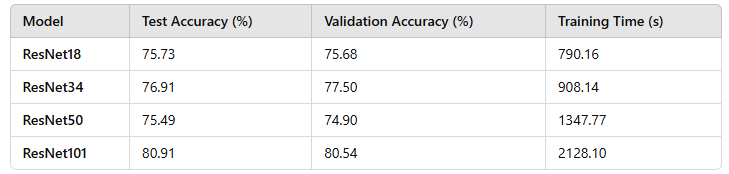
